In [1]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
train_df.shape

(7500, 17)

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
test_df.shape

(2500, 16)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [12]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

# БАЗОВОЕ РЕШЕНИЕ

In [13]:
train_df['Annual Income'].median()

1168386.0

In [14]:
train_df['Years in current job'].mode()

0    10+ years
dtype: object

In [15]:
train_df['Months since last delinquent'].median()

32.0

In [16]:
train_df['Bankruptcies'].mode()

0    0.0
dtype: float64

In [17]:
train_df['Credit Score'].median()

731.0

In [18]:
train_df_base_solution = train_df.copy()
train_df_base_solution.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


#### заполнение количественных признаков медианами для базового решения

In [19]:
train_df_base_solution['Annual Income'] =\
    train_df_base_solution['Annual Income'].fillna(train_df_base_solution['Annual Income'].median())

train_df_base_solution['Months since last delinquent'] =\
    train_df_base_solution['Months since last delinquent'].fillna(train_df_base_solution['Months since last delinquent'].median())

train_df_base_solution['Credit Score'] =\
    train_df_base_solution['Credit Score'].fillna(train_df_base_solution['Credit Score'].median())

In [20]:
print(train_df_base_solution['Annual Income'].isna().sum())
print(train_df_base_solution['Months since last delinquent'].isna().sum())
print(train_df_base_solution['Credit Score'].isna().sum())

0
0
0


#### заполнение категориальных признаков модами для базового решения

In [21]:
train_df_base_solution['Years in current job'] =\
    train_df_base_solution['Years in current job'].fillna(train_df_base_solution['Years in current job'].mode()[0])
train_df_base_solution['Bankruptcies'] =\
    train_df_base_solution['Bankruptcies'].fillna(train_df_base_solution['Bankruptcies'].mode()[0])

In [22]:
print(train_df_base_solution['Years in current job'].isna().sum())
print(train_df_base_solution['Bankruptcies'].isna().sum())

0
0


#### проверка на отсутствие пропусков в датафрейме для базового решения

In [23]:
train_df_base_solution.isna().sum().sum()

0

In [24]:
train_df_base_solution.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### получение get_dummies для категориальных переменных и удаление переменной из которой делали get_dummies

In [25]:
list_of_features_to_get_dummies = ['Home Ownership',
                                   'Years in current job',
                                   'Purpose', 
                                   'Term']

for feature in list_of_features_to_get_dummies:
    # получение get_dummies
    train_df_base_solution = pd.concat([train_df_base_solution, 
                                        pd.get_dummies(pd.get_dummies(train_df_base_solution[feature],
                                        prefix=feature))],
                                        axis=1)
    # удаление признака
    train_df_base_solution = train_df_base_solution.drop([feature], axis=1)

In [26]:
train_df_base_solution.dtypes

Annual Income                     float64
Tax Liens                         float64
Number of Open Accounts           float64
Years of Credit History           float64
Maximum Open Credit               float64
Number of Credit Problems         float64
Months since last delinquent      float64
Bankruptcies                      float64
Current Loan Amount               float64
Current Credit Balance            float64
Monthly Debt                      float64
Credit Score                      float64
Credit Default                      int64
Home Ownership_Have Mortgage        uint8
Home Ownership_Home Mortgage        uint8
Home Ownership_Own Home             uint8
Home Ownership_Rent                 uint8
Years in current job_1 year         uint8
Years in current job_10+ years      uint8
Years in current job_2 years        uint8
Years in current job_3 years        uint8
Years in current job_4 years        uint8
Years in current job_5 years        uint8
Years in current job_6 years      

#### Разбиение на train и test

In [27]:
TARGET_NAME = 'Credit Default'

X = train_df_base_solution.drop(TARGET_NAME, axis=1)
y = train_df_base_solution[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### Масштабрование данных

In [28]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm = scaler.fit_transform(X_train_norm)
X_test_norm = scaler.transform(X_test_norm)

In [29]:
model_lr = LogisticRegression()
model_lr.fit(X_train_norm, y_train)

evaluate_preds(model_lr, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      3771
           1       0.81      0.29      0.43      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.63      0.65      5250
weighted avg       0.79      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1616
           1       0.77      0.25      0.38       634

    accuracy                           0.77      2250
   macro avg       0.77      0.61      0.62      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1569   47
1                474  160


In [30]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.55},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.53      0.51      0.52      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.73      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.51      0.49      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1312  304
1                322  312


# f1-score на TEST на базовом решении 0.65!!!

# EDA

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [31]:
train_df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [32]:
train_df.shape

(7500, 17)

In [33]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [34]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### !!!!!!!!!! <исправить> составление списков числовых и категориальных переменных

In [36]:
print('\nчисловые переменные:\n', train_df.select_dtypes(np.number).columns.to_list())
print('\nкатегориальные переменные:\n', train_df.select_dtypes(np.object).columns.to_list())


числовые переменные:
 ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']

категориальные переменные:
 ['Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [37]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History',
                      'Maximum Open Credit', 'Number of Credit Problems',
                      'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
                      'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                      'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 
                     'Months since last delinquent', 
                     'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 
                     'Term', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies']

### Целевая переменная - Credit Default

#### Баланс классов целевой переменной

In [38]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Корреляция целевой переменной с базовыми признаками

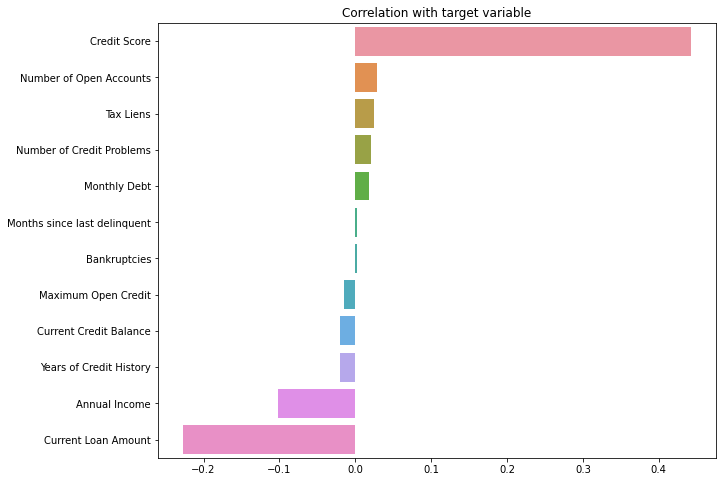

In [39]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Home Ownership / домовладение

In [40]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

#### целесообразно написать функцию по созданию dummy переменных из категорий признака

In [41]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

#### проверка согласованности частот Home Ownership в разрезе целевой переменной используя Хи-квадрат Пирсона

*напишем функцию которая будет проверять согласованность частот любого категориального признака при помощи хи квадрата Пирсона*

In [42]:
def check_frequencies_match_of_a_categorical_feature_with_chi2(df, feature_name, target_name):
    
    # создание копии принимаемого датафрейма, функция не вносит никаких изменений в данные
    X = df.copy()
    
    # создание поля индекса для удобности подсчёта в pivot_table... aggfunc='count'
    X['Id'] = X.index
    
    # создание списка категорий признака
    list_of_categories = list(df[feature_name].unique())
    print('\nlist of categories:\n', list_of_categories)
    
    # создание списка уникальных пар категорий признака
    list_of_categories_pairs = [list(i) for i in list(itertools.combinations(list_of_categories, 2))]
#     print('\nlist_of_categories_pairs:\n', list_of_categories_pairs)
    
    # рассчёт p-value для хи квадрата для каждой пары из списка уникальных пар категорий признака
    df_of_categories_pairs_with_chi2_p_value = pd.DataFrame()
    for categories_pair in list_of_categories_pairs:
        feature_and_target = X.loc[df[feature_name].isin(categories_pair), ['Id', feature_name, target_name]]
        table = feature_and_target.pivot_table(values='Id', index=feature_name, columns=target_name, aggfunc='count')
#         print('\ntable:\n', table)

        chi2, p, _, _ = chi2_contingency(table)
        
        try:
            category_1_proportion_of_0 = table[0][categories_pair[0]]
#             if category_1_proportion_of_0 is None or category_1_proportion_of_0 == 'NaN':
#                 category_1_proportion_of_0 = 0
        except:
            category_1_proportion_of_0 = 0
        try:
            category_1_proportion_of_1 = table[1][categories_pair[0]]
#             if category_1_proportion_of_1 is None or category_1_proportion_of_1 == 'NaN':
#                 category_1_proportion_of_1 = 0
        except:
            category_1_proportion_of_1 = 0
        try:
            category_2_proportion_of_0 = table[0][categories_pair[1]]
#             if category_2_proportion_of_0 is None or category_2_proportion_of_0 == 'NaN':
#                 category_2_proportion_of_0 = 0
        except:
            category_2_proportion_of_0 = 0
        try:
            category_2_proportion_of_1 = table[1][categories_pair[1]]
#             if category_2_proportion_of_1 is None or category_2_proportion_of_1 == 'NaN':
#                 category_2_proportion_of_1 = 0
        except:
            category_2_proportion_of_1 = 0       
        
        # запись строки в парами и p-value в датафрейм
        df_of_categories_pairs_with_chi2_p_value = df_of_categories_pairs_with_chi2_p_value.append({
            'cat_1': categories_pair[0],
            'cat_2': categories_pair[1],
            'cat_1_prop_of_0_and_1': f'{category_1_proportion_of_0} : {category_1_proportion_of_1}',
            'cat_2_prop_of_0_and_1': f'{category_2_proportion_of_0} : {category_2_proportion_of_1}',
            'cat_1_prop_of_1': 
                f'{round(category_1_proportion_of_1 / (category_1_proportion_of_0 + category_1_proportion_of_1), 2)}',
            'cat_2_prop_of_1': 
                f'{round(category_2_proportion_of_1 / (category_2_proportion_of_0 + category_2_proportion_of_1), 2)}',
            'chi2_p_val': round(p, 3),
            'chi2_p_val_>_alpha': True if p > 0.05 else False
        }, ignore_index=True)

    return df_of_categories_pairs_with_chi2_p_value

посмотрим результат работы функции check_frequencies_match_of_a_categorical_feature_with_chi2 рассчитав согласованность частот признака Home Ownership в разрезе целевой переменной

In [43]:
df = train_df.copy()
check_frequencies_match_of_a_categorical_feature_with_chi2(df, feature_name='Home Ownership', target_name=TARGET_NAME)


list of categories:
 ['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,Own Home,455 : 192,0.3,Home Mortgage,2721 : 916,0.25,0.019,0.0
1,Own Home,455 : 192,0.3,Rent,2201 : 1003,0.31,0.441,1.0
2,Own Home,455 : 192,0.3,Have Mortgage,10 : 2,0.17,0.509,1.0
3,Home Mortgage,2721 : 916,0.25,Rent,2201 : 1003,0.31,0.000,0.0
4,Home Mortgage,2721 : 916,0.25,Have Mortgage,10 : 2,0.17,0.730,1.0
5,Rent,2201 : 1003,0.31,Have Mortgage,10 : 2,0.17,0.435,1.0


#### построим график распределения частот Home Ownership для наглядности

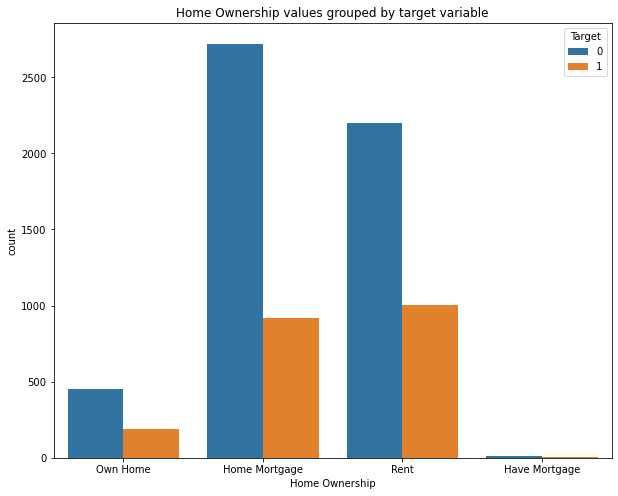

In [44]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=train_df)
plt.title('Home Ownership values grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Наблюдения:

    - Own Home, Rent и Have Mortgage согласованы.
    - Home Mortgage и Have Mortgage также согласованы.
    - Согласованность Have Mortgage со всеми другими категориями группы вероятно объясняется малым количеством объектов этой категории.
Идеи:

    - Создать новый бинарный признак G_home_ownership_reduced_to_2_categories путём сокращения признака Home Ownership до 2х категорий. При этом категорию Have Mortgage объединить с категорией Home Mortgage в виду большего значения p-value.

#### напишем функцию по созданию нового бинарного признака G_home_ownership_reduced_to_binary путём сокращения признака Home Ownership до 2х категорий

In [45]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

Итого, по признаку Home Ownership созданы механизмы как по генерации dummy-признаков из категорий оригинального признака, так и создания нового бинарного признака путём объединения категорий оригинального признака с согласованными по хи квадрату Пирсона частотами в две категории. 

### Years in current job / количество лет на текущем месте работы

посмотрим на количество пропусков в признаке

In [46]:
train_df['Years in current job'].isna().value_counts()

False    7129
True      371
Name: Years in current job, dtype: int64

есть пропуски

посмотрим на категории признака

In [47]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### Рассчитаем согласованность частот признака Years in current job в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2, при этом пропуски в признаке выделим в дополнительную категорию 

In [48]:
df = train_df.copy()
df['Years in current job'] = df['Years in current job'].fillna(value='not_indicated')

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Years in current job', target_name=TARGET_NAME)


list of categories:
 ['not_indicated', '10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years']


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,not_indicated,234 : 137,0.37,10+ years,1688 : 644,0.28,0.000,0.0
1,not_indicated,234 : 137,0.37,8 years,247 : 92,0.27,0.007,0.0
2,not_indicated,234 : 137,0.37,6 years,302 : 124,0.29,0.023,0.0
3,not_indicated,234 : 137,0.37,7 years,285 : 111,0.28,0.011,0.0
4,not_indicated,234 : 137,0.37,5 years,371 : 145,0.28,0.007,0.0
5,not_indicated,234 : 137,0.37,1 year,362 : 142,0.28,0.008,0.0
6,not_indicated,234 : 137,0.37,< 1 year,404 : 159,0.28,0.007,0.0
7,not_indicated,234 : 137,0.37,4 years,338 : 131,0.28,0.007,0.0
8,not_indicated,234 : 137,0.37,3 years,450 : 170,0.27,0.002,0.0
9,not_indicated,234 : 137,0.37,2 years,512 : 193,0.27,0.002,0.0


In [49]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Частоты всех категорий признака, кроме созданной вместо пропусков not_indicated, согласованы между собой.
    - В категории not_indicated в разрезе целевой переменной наблюдается значительный процент значений = 1, что значительно выше, чем в какой либо другой категории признака.
Идеи:

    - Создать новый бинарный признак G_years_in_current_job_reduced_to_2_categories путём сокращения признака Years in current job до 2х категорий: 1 - куда войдут все пропуски и 0 - все указаные категории.

#### напишем функцию по созданию нового бинарного признака G_years_in_current_job_reduced_to_binary путём сокращения признака Years in current job до 2х категорий

In [50]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

### Purpose / цель кредита

In [51]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

#### рассчитаем согласованность частот признака Purpose в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [52]:
df = train_df.copy()

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Purpose', target_name=TARGET_NAME)


list of categories:
 ['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses', 'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,debt consolidation,4290 : 1654,0.28,other,468 : 197,0.3,0.351,1.0
1,debt consolidation,4290 : 1654,0.28,home improvements,304 : 108,0.26,0.515,1.0
2,debt consolidation,4290 : 1654,0.28,take a trip,27 : 10,0.27,0.940,1.0
3,debt consolidation,4290 : 1654,0.28,buy a car,72 : 24,0.25,0.618,1.0
4,debt consolidation,4290 : 1654,0.28,small business,12 : 14,0.54,0.006,0.0
5,debt consolidation,4290 : 1654,0.28,business loan,74 : 55,0.43,0.000,0.0
6,debt consolidation,4290 : 1654,0.28,wedding,11 : 4,0.27,0.851,1.0
7,debt consolidation,4290 : 1654,0.28,educational expenses,9 : 1,0.1,0.366,1.0
8,debt consolidation,4290 : 1654,0.28,buy house,25 : 9,0.26,0.987,1.0
9,debt consolidation,4290 : 1654,0.28,medical bills,49 : 22,0.31,0.648,1.0


In [53]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Частоты признака по их согласованности и простой логике (где согласованности нет в виду очень малого количества объектов данной категории) можно разделить на 2 группы:
    1я: 'debt consolidation', 'other', 'home improvements', 
       'buy a car', 'medical bills', 'major purchase', 'take a trip',
       'buy house', 'small business', 'wedding', 'moving',
       'educational expenses', 'vacation', 'renewable energy'
    2я: 'business loan', 'small business'

Идеи:

    - Создать новый бинарный признак G_purpose_reduced_to_2_categories путём сокращения признака Purpose до 2х категорий.

#### напишем функцию по созданию нового бинарного признака G_purpose_reduced_to_binary путём сокращения признака Purpose до 2х категорий

In [54]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

### Term / срок кредита

In [55]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Наблюдения:

    - В признаке нет пропусков и всего 2 категории.
Идеи:

    - Создать новый бинарный признак G_term_transformed_to_binary путём замены строковых значений признака Term на 1 и 0.

#### напишем функцию по созданию нового бинарного признака G_term_transformed_to_binary путём трансформации значений признака Term в 0 и 1

In [56]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

### Tax Liens / налоговые обременения

In [57]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [58]:
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

#### проверка согласованности частот используя Хи-квадрат Пирсона

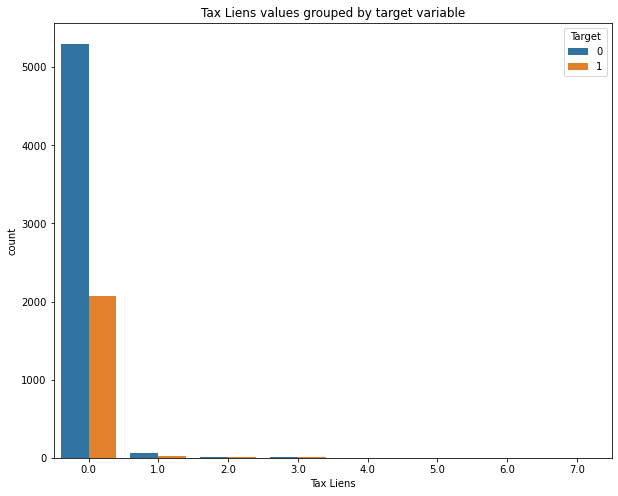

In [59]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=train_df)
plt.title('Tax Liens values grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

*проверка согласованности частот категорий 0 и 1*

In [60]:
df = train_df.copy()
variable_name = 'Tax Liens'
df['Id'] = df.index

In [61]:
variable_and_target = df.loc[df[variable_name].isin([0, 1]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24


In [62]:
chi2, p, _, _ = chi2_contingency(table)
p

0.956212700856196

P-value получилось больше выбранного уровня значимости (0.05), соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории 0 и 1 одинаково влияют на целевую переменную и их можно объединить в одну категорию.

*проверка согласованности частот категорий 2, 3, 4, и 5*

In [63]:
variable_and_target = df.loc[df[variable_name].isin([2, 3, 4, 5]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
2.0,15,15
3.0,5,5
4.0,3,3
5.0,1,1


Частоты категорий 2, 3, 4, и 5 идентичны, видно и без статистических критериев. Можно объединять в одну категорию.

проверка согласованности частот категорий 6 и 7

In [64]:
variable_and_target = df.loc[df[variable_name].isin([6, 7]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0
Tax Liens,
6.0,2
7.0,1


Частоты категорий 6 и 7 идентичны, видно и без статистических критериев, но в эти категории попадает всего 3 объекта на train датасете и всего 1 объект на test датасете. Целесообразно объединить с категориями 1 и 0, как наиболее близкими в разрезе целевой переменной.

#### напишем функцию по созданию признака G_tax_liens_reduced_to_binary путём сокращения признака Tax Liens до 2х категорий

In [65]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

### Number of Credit Problems / количество проблем с кредитом

In [66]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

#### рассчитаем согласованность частот признака Number of Credit Problems в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [67]:
df = train_df.copy()

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Number of Credit Problems', target_name=TARGET_NAME)


list of categories:
 [1.0, 0.0, 3.0, 2.0, 6.0, 4.0, 5.0, 7.0]


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,1.0,641 : 241,0.27,0.0,4654 : 1815,0.28,0.678,1.0
1,1.0,641 : 241,0.27,3.0,21 : 14,0.4,0.147,1.0
2,1.0,641 : 241,0.27,2.0,60 : 33,0.35,0.123,1.0
3,1.0,641.0 : 241.0,0.27,6.0,4.0 : nan,nan,NaN,0.0
4,1.0,641 : 241,0.27,4.0,3 : 6,0.67,0.025,0.0
5,1.0,641 : 241,0.27,5.0,3 : 4,0.57,0.182,1.0
6,1.0,641.0 : 241.0,0.27,7.0,1.0 : nan,nan,NaN,0.0
7,0.0,4654 : 1815,0.28,3.0,21 : 14,0.4,0.168,1.0
8,0.0,4654 : 1815,0.28,2.0,60 : 33,0.35,0.143,1.0
9,0.0,4654.0 : 1815.0,0.28,6.0,4.0 : nan,nan,NaN,0.0


In [68]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Как видно категории 0 и 1 признака согласуются.
    - В категориях от 2 и выше наблюдается увеличение количества объектов с целевой переменной = 1, однако прямая корреляция между увеличением значения признака и ростом количества объектов с целевой переменной = 1 не выстраивается. Возможно в виду малочисленности объектов признака отнесённых ко 2й и выше категориям.
Идеи:

    - Перевести признак в разряд категориальных (уже сделано).
    - Создать новый бинарный признак G_number_of_credit_problems_reduced_to_binary путём объединения категорий признака в две:
    1я: 0 и 1,
    2я: 2 и выше

#### напишем функцию по созданию признака G_number_of_credit_problems_reduced_to_binary путём сокращения признака Number of Credit Problems до 2х категорий

In [69]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

### Bankruptcies / банкротства

In [70]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [71]:
train_df['Bankruptcies'].isna().value_counts()

False    7486
True       14
Name: Bankruptcies, dtype: int64

#### рассчитаем согласованность частот признака Number of Credit Problems в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [72]:
df = train_df.copy()

df['Bankruptcies'] = df['Bankruptcies'].fillna('not_indicated')
pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Bankruptcies', target_name=TARGET_NAME)


list of categories:
 [1.0, 0.0, 3.0, 'not_indicated', 2.0, 4.0]


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,1,569 : 217,0.28,0,4782 : 1878,0.28,0.760,1.0
1,1,569 : 217,0.28,3,5 : 2,0.29,0.713,1.0
2,1,569 : 217,0.28,not_indicated,10 : 4,0.29,0.825,1.0
3,1,569 : 217,0.28,2,20 : 11,0.35,0.450,1.0
4,1,569 : 217,0.28,4,1 : 1,0.5,0.933,1.0
5,0,4782 : 1878,0.28,3,5 : 2,0.29,0.690,1.0
6,0,4782 : 1878,0.28,not_indicated,10 : 4,0.29,0.790,1.0
7,0,4782 : 1878,0.28,2,20 : 11,0.35,0.484,1.0
8,0,4782 : 1878,0.28,4,1 : 1,0.5,0.920,1.0
9,3,5 : 2,0.29,not_indicated,10 : 4,0.29,1.000,1.0


In [73]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Как видно категории 0 и 1 признака согласуются.
    - В категориях от 2 и выше наблюдается увеличение количества объектов с целевой переменной = 1, однако прямая корреляция между увеличением значения признака и ростом количества объектов с целевой переменной = 1 не выстраивается. Возможно в виду малочисленности объектов признака отнесённых ко 2й и выше категориям.
Идеи:

    - Перевести признак в разряд категориальных (уже сделано).
    - Создать новый бинарный признак G_number_of_credit_problems_reduced_to_binary путём объединения категорий признака в две:
    1я: 0, 1 и пропуски, так как они в разрезе целевой переменной наиболее близки к первой категории,
    2я: 2 и выше

#### напишем функцию по созданию признака G_bankruptcies_reduced_to_binary путём сокращения признака Bankruptcies до 2х категорий

In [74]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
    return X

# не забыть заполнить пропуски в оригинальном признаке Bankruptcies

In [75]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

### Распределение числовых признаков

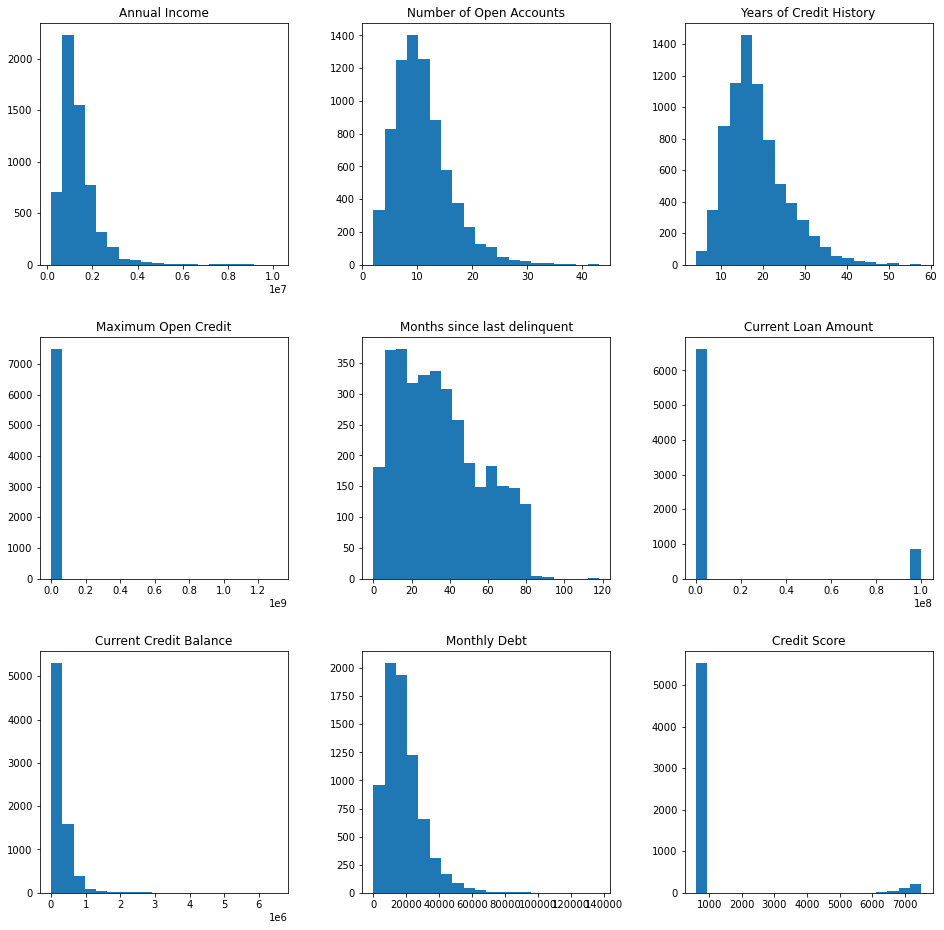

In [76]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

Наблюдения:

- Распределения Number of Open Accounts/количество открытых счетов, Years of Credit History/количество лет кредитной истории выгядят абсолютно логично.

Идеи:

- Т.к. пропусков в данных переменных нет, то дополнительно их изучать не требуется.

# ВЕЩЕСТВЕННЫЕ ПРИЗНАКИ

### Проверим распределения вещественных признаков на трейне и тесте

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


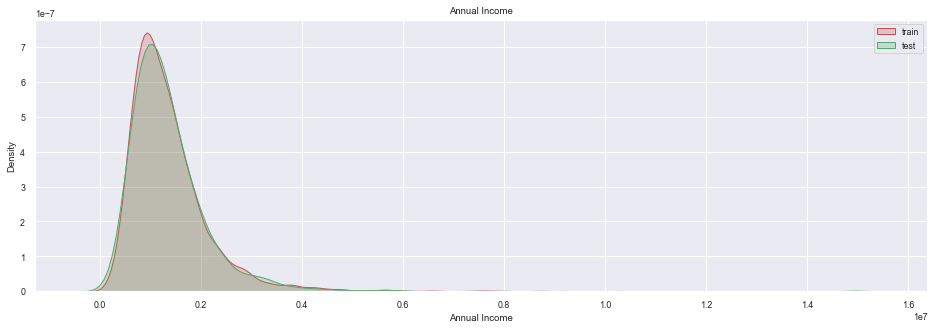

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


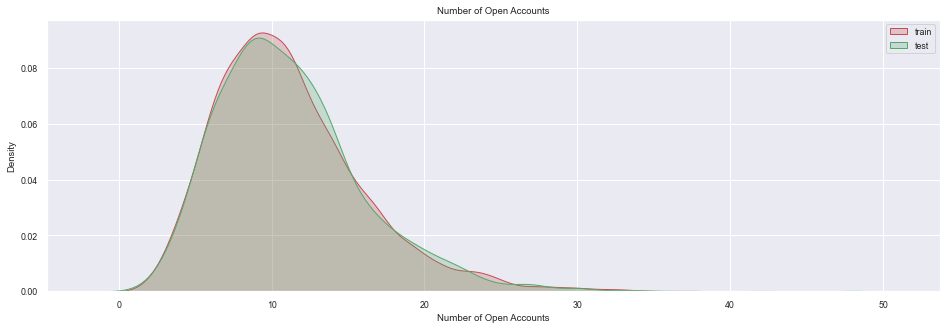

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


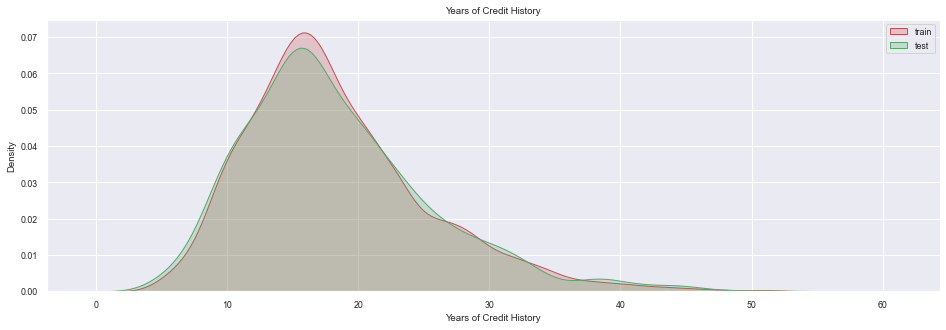

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


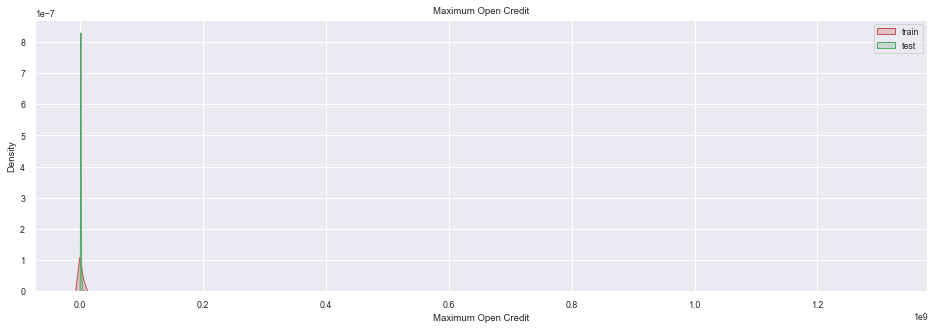

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


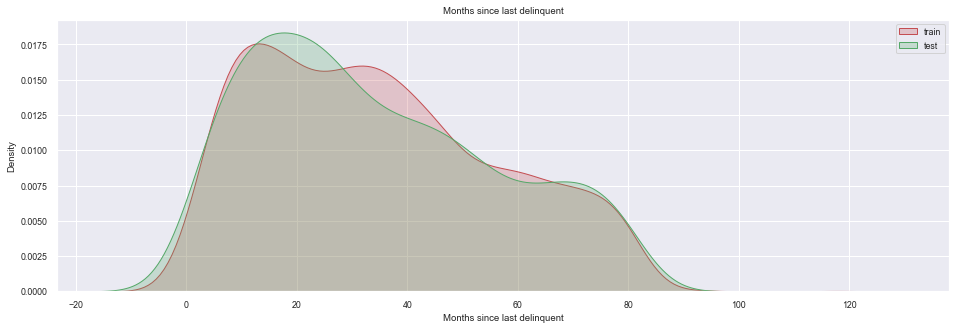

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


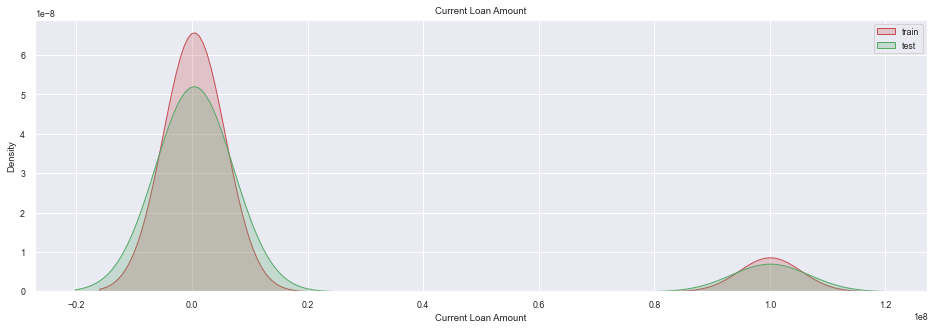

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


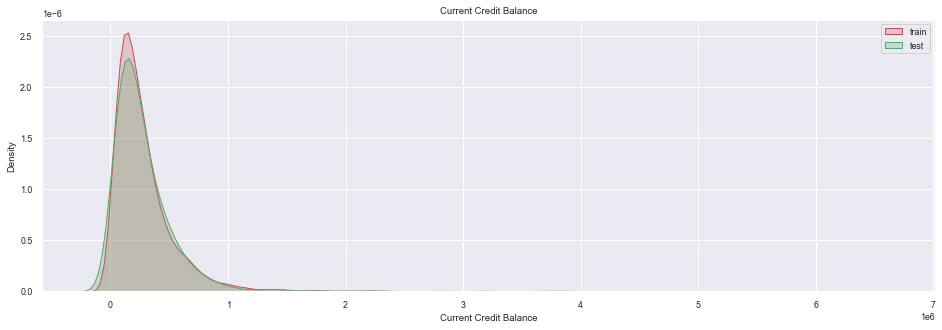

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


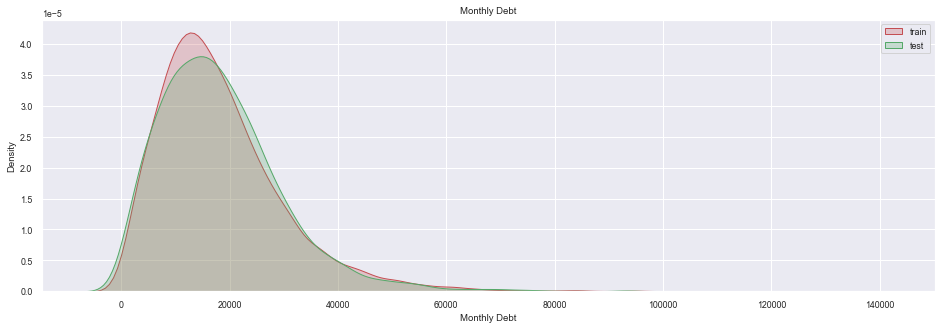

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


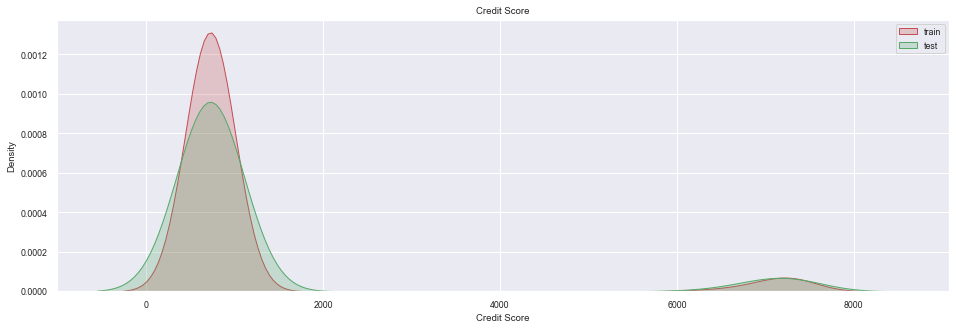

In [77]:
figsize = (16, 5)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

матожидания вещественных признаков на train и на test коррелируют

### Annual Income/годовой доход

In [78]:
train_df['Annual Income'].isna().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

есть пропуски

#### посмотрим как распределяется целевая переменная на значениях признака и его пропусках

In [79]:
df = train_df.copy()

df['Annual Income'] = df['Annual Income'].fillna('not_indicated')
df.loc[df['Annual Income'] != 'not_indicated', 'Annual Income'] = 'indicated'

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Annual Income', target_name=TARGET_NAME)


list of categories:
 ['indicated', 'not_indicated']


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,indicated,4359 : 1584,0.27,not_indicated,1028 : 529,0.34,0.0,0.0


In [80]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Как видно на пропусках доля объектов с целевой переменной = 1 выше, чем на объектах, где пропусков нет.
Идеи:

    - Создать бинарный признак G_anual_income_was_nan путём присвоения всем объектам значения 0, кроме тех, где был пропуск, там значение будет = 1.

#### напишем функцию по созданию признака G_anual_income_was_nan путём присвоения всем объектам значения 0, кроме тех, где был пропуск, там значение будет = 1

In [81]:
def generate_G_anual_income_was_nan(X):
    X['G_anual_income_was_nan'] = 0
    X.loc[X['Annual Income'].isna(), 'G_anual_income_was_nan'] = 1  
    return X

проверка

In [82]:
df = train_df.copy()
generate_G_anual_income_was_nan(df)['G_anual_income_was_nan'].value_counts()

0    5943
1    1557
Name: G_anual_income_was_nan, dtype: int64

#### посмотрим на распределения Annual Income на train и test

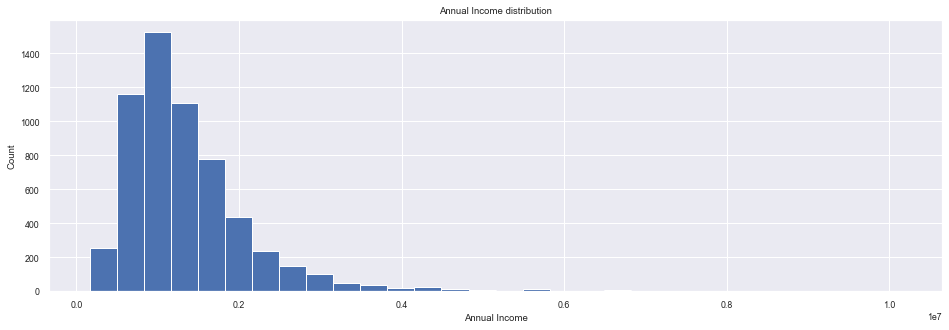

In [83]:
plt.figure(figsize = (16, 5))

train_df['Annual Income'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Annual Income')

plt.title('Annual Income distribution')
plt.show()

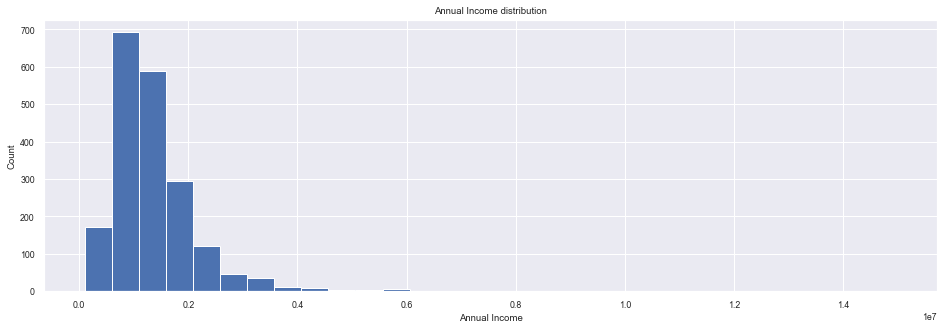

In [84]:
plt.figure(figsize = (16, 5))

test_df['Annual Income'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Annual Income')

plt.title('Annual Income distribution')
plt.show()

уберём 100 максимальных значений на train

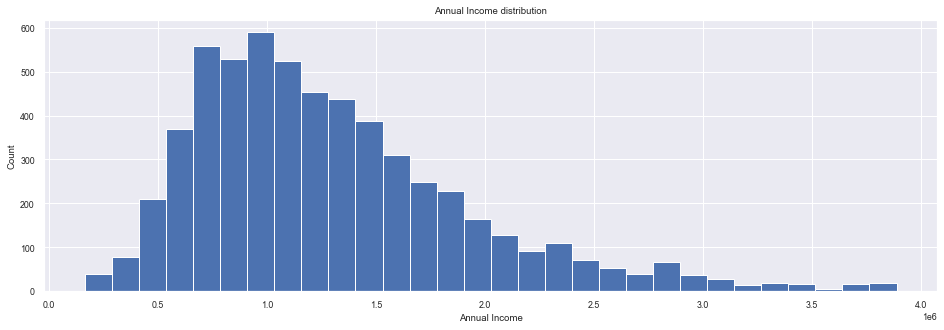

In [85]:
plt.figure(figsize = (16, 5))

train_df[~train_df['Annual Income'].isna()]['Annual Income'].sort_values()[:-100].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Annual Income')

plt.title('Annual Income distribution')
plt.show()

посмотрим на эти 100 максимальных значений Annual Income в разрезе целевой переменной

In [86]:
train_df[~train_df['Annual Income'].isna()].sort_values('Annual Income').tail(100)['Credit Default'].value_counts()

0    88
1    12
Name: Credit Default, dtype: int64

посмотрим на 100 минимальных значений Annual Income в разрезе целевой переменной

In [87]:
train_df[~train_df['Annual Income'].isna()].sort_values('Annual Income').head(100)['Credit Default'].value_counts()

0    67
1    33
Name: Credit Default, dtype: int64

#### оценка признака Annual Income в разрезе целевой переменной

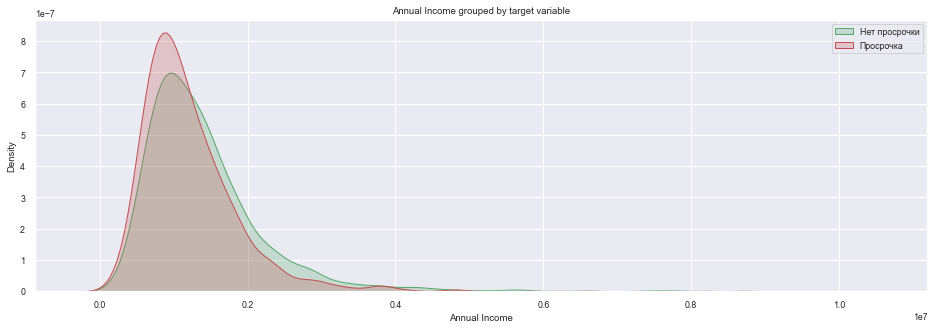

In [88]:
plt.figure(figsize=(16, 5))

sns.kdeplot(train_df.loc[train_df[TARGET_NAME] == 0, 'Annual Income'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(train_df.loc[train_df[TARGET_NAME] == 1, 'Annual Income'], shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [89]:
mannwhitneyu(train_df.loc[train_df[TARGET_NAME] == 0, 'Annual Income'], 
             train_df.loc[train_df[TARGET_NAME] == 1, 'Annual Income'])

MannwhitneyuResult(statistic=5534342.5, pvalue=0.031334788783133206)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

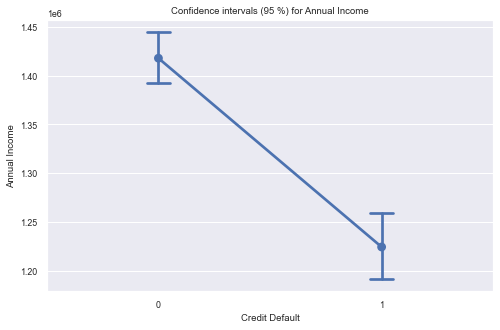

In [90]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=train_df[['Annual Income', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

#### посмотрим, целесообразно ли разбить признак на категории с одновременным таргет энкодингом. для этого напишем вот такую вот замечательную функцию

In [91]:
def check_whether_categorization_with_target_encoding_is_valid(df, number_of_categories, 
                                                               feature_name, target_name, 
                                                               push_right_min_outliers, push_left_max_outliers):
    
    # функция разбивает признак на заданное количество категорий
    # путём разбиения пространства признака на равные интервалы
    # и просчитывает пропорцию объектов с целевой переменной == 1
    # к общему числу объектов в данной категории.
    # тем самым выясняется целесообразность категорирования с таргет энкодингом данного признака.
    # NB! функция создаёт для пропусков отдельную, дополнительную к number_of_categories, подкатегорию.
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы)
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
        
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    
    additional_category = 0
    if X[feature_name].isna().sum() != 0:
        category_stat = X.loc[X[feature_name].isna(), target_name].value_counts()
        
        print(f'NaN objects detected!')
        print(f'additional category for NaN objects was created!')
        print(f'proportion of objects where target is 1: {round((category_stat[1] / sum(category_stat)), 2)}')
        print(f'number of objects: {sum(category_stat)}\n')
        additional_category = 1
            
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(X[feature_name] >= limits_of_categories[i]) & 
                      (X[feature_name] < limits_of_categories[i + 1]), target_name].value_counts()
            print(f'in range from {limits_of_categories[i]} to {limits_of_categories[i + 1]}')
            print(f'proportion of objects where target is 1: {round((category_stat[1] / sum(category_stat)), 2)}')
            print(f'number of objects: {sum(category_stat)}\n')

        except:
            None
        i += 1
    
    print(f'----------------------------')
    print(f'number of categories: {number_of_categories} + {additional_category}')
    print(f'feature name: {feature_name}')
    print(f'target name: {target_name}\n\n')

#### проверка работы функции

In [92]:
check_whether_categorization_with_target_encoding_is_valid(df=train_df.copy(), 
                                                           number_of_categories=10, 
                                                           feature_name='Annual Income',
                                                           target_name=TARGET_NAME,
                                                           push_right_min_outliers=True, 
                                                           push_left_max_outliers=True)

NaN objects detected!
additional category for NaN objects was created!
proportion of objects where target is 1: 0.34
number of objects: 1557

in range from 447499.4 to 747170.8200000001
proportion of objects where target is 1: 0.34
number of objects: 1033

in range from 747170.8200000001 to 1046842.24
proportion of objects where target is 1: 0.3
number of objects: 1422

in range from 1046842.24 to 1346513.6600000001
proportion of objects where target is 1: 0.26
number of objects: 1138

in range from 1346513.6600000001 to 1646185.08
proportion of objects where target is 1: 0.24
number of objects: 876

in range from 1646185.08 to 1945856.5
proportion of objects where target is 1: 0.23
number of objects: 570

in range from 1945856.5 to 2245527.92
proportion of objects where target is 1: 0.2
number of objects: 277

in range from 2245527.92 to 2545199.34
proportion of objects where target is 1: 0.2
number of objects: 221

in range from 2545199.34 to 2844870.76
proportion of objects where ta

In [93]:
check_whether_categorization_with_target_encoding_is_valid(df=train_df.copy(), 
                                                           number_of_categories=10, 
                                                           feature_name='Annual Income',
                                                           target_name=TARGET_NAME,
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

NaN objects detected!
additional category for NaN objects was created!
proportion of objects where target is 1: 0.34
number of objects: 1557

in range from 164597.0 to 1163071.7
proportion of objects where target is 1: 0.31
number of objects: 2940

in range from 1163071.7 to 2161546.4
proportion of objects where target is 1: 0.24
number of objects: 2324

in range from 2161546.4 to 3160021.0999999996
proportion of objects where target is 1: 0.19
number of objects: 489

in range from 3160021.0999999996 to 4158495.8
proportion of objects where target is 1: 0.2
number of objects: 105

in range from 4158495.8 to 5156970.5
proportion of objects where target is 1: 0.12
number of objects: 43

in range from 5156970.5 to 6155445.199999999
proportion of objects where target is 1: 0.06
number of objects: 18

in range from 6155445.199999999 to 7153919.899999999
proportion of objects where target is 1: 0.14
number of objects: 7

in range from 7153919.899999999 to 8152394.6
in range from 8152394.6 to

#### напишем ещё одну замечательную функцию для генерации нового признака путём категорирования оригинального с одновременным таргет энкодингом

In [94]:
def generate_target_encoded_feature_for_a_numerical_feature(df, number_of_categories, 
                                                            feature_name, target_name, 
                                                            push_right_min_outliers_in_feature_name, 
                                                            push_left_max_outliers_in_feature_name):
    # функция генерирует новый признак
    # путём разбиения пространства оригинального признака на заданное количество равных интервалов
    # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
    # к общему числу объектов на каждом интервале
    # с присвоением значения вероятности какждому объекту в виде значения нового признака.
    # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
    # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
    # при генерации нового признака используя действительную функцию
    # следует проверить целесообразность такого действия 
    # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
    # значений равных 2.5% от минимума и 2.5% от максимума соответственно
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers_in_feature_name:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers_in_feature_name:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
    
    # выявление минимального и максимального значений на пространстве значений исходного признака
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    # создание интервалов из пространства значений исходного признака
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    # генерация имени нового признака
    new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'
    
    # заполнение нового признака средним значением целевой переменной -
    # перестраховка, чтобы избежать возможности пропусков
    X[new_feature_name] = X[target_name].mean()
    
    # заполнение пропусков в признаке средним значением целевой переменной на объектах,
    # где есть пропуски в признаках
    X.loc[df[feature_name].isna(), new_feature_name] = X.loc[df[feature_name].isna(), target_name].mean()
    
    # присвоение каждому объекту значения нового признака равного вероятности 
    # появления значения целевой переменной == 1 на заданном интервале оригинального признака
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                      (df[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
            
            X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                  (df[feature_name] < limits_of_categories[i + 1]), 
                  new_feature_name] = round((category_stat[1] / sum(category_stat)), 3) 
            
        except:
            None

        i += 1
        
    return X

#### проверка работы функции

In [95]:
df['Annual Income'].isna().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

как видно в признаке есть пропуски

In [96]:
df = generate_target_encoded_feature_for_a_numerical_feature(df=train_df.copy(), 
                                                             number_of_categories=6, 
                                                             feature_name='Annual Income',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)

In [97]:
df['G_annual_income_target_encoded'].value_counts()

0.271000    1944
0.320000    1820
0.339756    1557
0.234000    1126
0.199000     448
0.281733     298
0.155000     219
0.193000      88
Name: G_annual_income_target_encoded, dtype: int64

как видно, для пропусков (1557 объектов) была создана отдельная, дополнительная подкатегория с присвоением значения вероятности target == 1

Наблюдения:

    - Распределение годового дохода выглядит логично.
    - Наличие хвоста справа объясняется наличием людей, которые много зарабатывают.
    - У 100 объектов с максимальными значениями доля объектов с целевой переменной = 1 очень низкая - 0.12, а у 100 объектов с минимальными значениями высокая - 0.33, в то время как в среднем по всему датасету 0.28.
    - Доверительные интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания признака разделённого на две группы в разрезе целевой переменной, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.
Идеи:

    - Создать дополнительный признак для пропусков (функция написана выше).
    - А ещё лучше создать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature

### Current Loan Amount / текущая сумма кредита

#### построим распределение признака на train и test датасетах

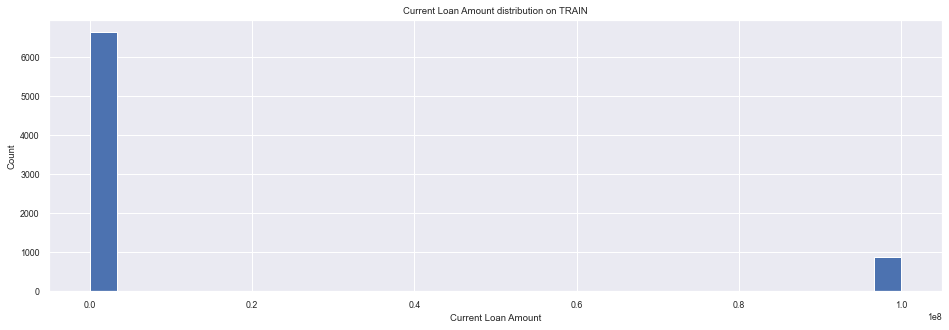

In [98]:
plt.figure(figsize = (16, 5))

train_df['Current Loan Amount'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution on TRAIN')
plt.show()

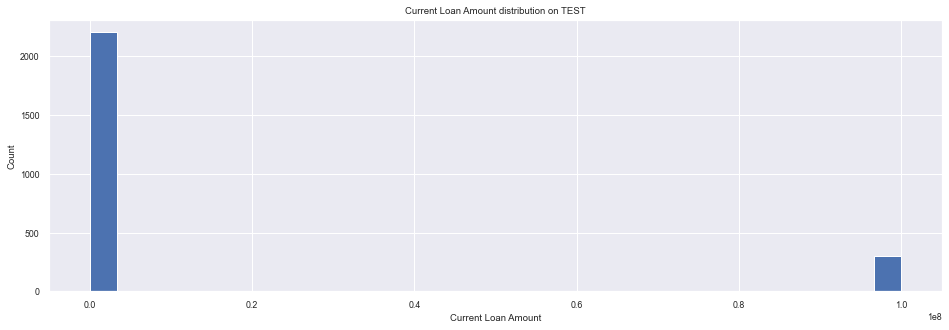

In [99]:
plt.figure(figsize = (16, 5))

test_df['Current Loan Amount'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution on TEST')
plt.show()

видны выбросы справа

#### посмотрим на минимальные значения

In [100]:
train_df['Current Loan Amount'].sort_values().head(10)

1404    11242.0
4467    21472.0
2735    21472.0
7144    21516.0
5861    21560.0
3226    21582.0
4863    21604.0
2982    21626.0
2688    21714.0
6558    21736.0
Name: Current Loan Amount, dtype: float64

#### посмотрим на максимальные значения

In [101]:
train_df['Current Loan Amount'].sort_values().tail(10)

4411    99999999.0
4404    99999999.0
4400    99999999.0
4396    99999999.0
4388    99999999.0
4384    99999999.0
732     99999999.0
4374    99999999.0
4555    99999999.0
0       99999999.0
Name: Current Loan Amount, dtype: float64

#### видны объекты с подозрительно высокими значениями Current Loan Amount = 99999999.0, посмотрим сколько их

In [102]:
train_df[train_df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

870

#### посмотрим на эти значения в разрезе целевой переменной

In [103]:
train_df.loc[train_df['Current Loan Amount'] == 99999999.0, TARGET_NAME].value_counts()

0    870
Name: Credit Default, dtype: int64

# БИНГО! ОБЪЕКТЫ С 'Current Loan Amount' == 99999999.0 МОГУТ БЫТЬ ОДНОЗНАЧНО ИДЕНТИФИЦИРОВАНЫ КАК ОБЪЕКТЫ КЛАССА 0 ЦЕЛЕВОЙ ПЕРЕМЕННОЙ

#### посмотрим сколько таких объектов на test датасете

In [104]:
test_df[test_df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].count()

297

# 297 КАРЛ!!! А ЭТО ПОЧТИ 12% ОТ TEST ДАТАСЕТА!!! И БЕЗ ВСЯКИХ МОДЕЛЕЙ!!! ВОТ ЭТО Я МОЛОДЕЦ!!!

#### построим распределения Current Loan Amount для train и test датасетов без обнаруженных выше очень полезных выбросов

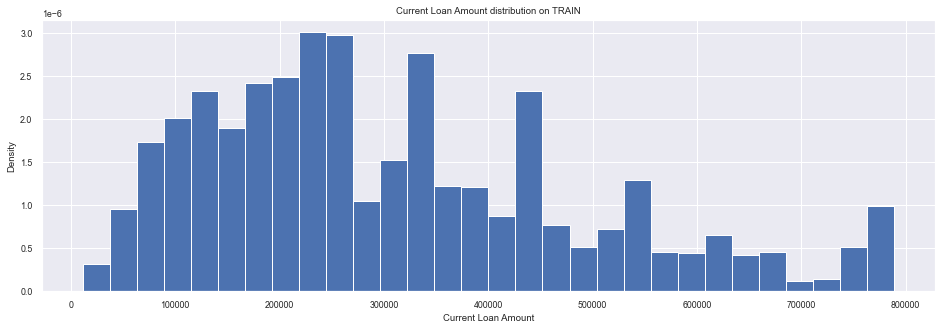

In [105]:
plt.figure(figsize = (16, 5))

train_df['Current Loan Amount'].sort_values()[:-870].hist(bins=30, density=True)
plt.ylabel('Density')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution on TRAIN')
plt.show()

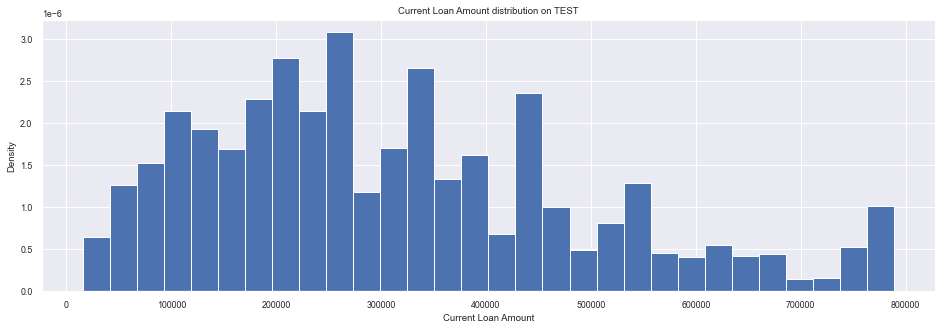

In [106]:
plt.figure(figsize = (16, 5))

test_df['Current Loan Amount'].sort_values()[:-297].hist(bins=30, density=True)
plt.ylabel('Density')
plt.xlabel('Current Loan Amount')

plt.title('Current Loan Amount distribution on TEST')
plt.show()

#### посмотрим также какие пропуски в других признаках попадают в выбросы на Current Loan Amount

In [107]:
train_df.loc[train_df['Current Loan Amount'].sort_values()[-870:].index].isna().sum()

Home Ownership                    0
Annual Income                     0
Years in current job             41
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent    499
Bankruptcies                      3
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

Наблюдения:

    - Объекты с Current Loan Amount = 99999999.0 все отнесены к классу 0 целевой переменной.
    - В объектах с Current Loan Amount = 99999999.0 имеются пропуски в других признаках.
    - Распределения на train и test схожи.
    
Идеи:

    - Исключить объекты с Current Loan Amount = 99999999.0 из обучения модели, а на test датафрейме присвоить всем таким объектам класс 0 в целевой переменной.

#### оценка признака Current Loan Amount (без выбросов) в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты без выбросов в Current Loan Amount

In [108]:
df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()

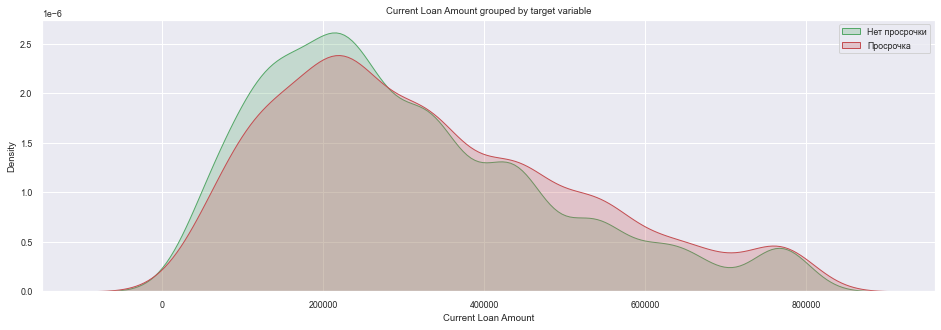

In [109]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Current Loan Amount'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Current Loan Amount'], shade=True, label='Просрочка', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [110]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Current Loan Amount'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Current Loan Amount'])

MannwhitneyuResult(statistic=4375163.0, pvalue=2.2854679965680805e-08)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

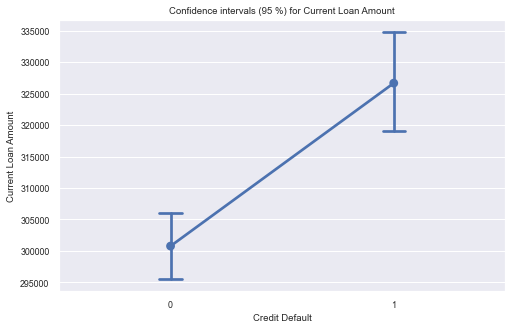

In [111]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=df[['Current Loan Amount', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

In [112]:
df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
# df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=10, 
                                                           feature_name='Current Loan Amount',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

in range from 11242.0 to 89020.8
proportion of objects where target is 1: 0.27
number of objects: 517

in range from 89020.8 to 166799.6
proportion of objects where target is 1: 0.28
number of objects: 1071

in range from 166799.6 to 244578.40000000002
proportion of objects where target is 1: 0.3
number of objects: 1358

in range from 244578.40000000002 to 322357.2
proportion of objects where target is 1: 0.32
number of objects: 952

in range from 322357.2 to 400136.0
proportion of objects where target is 1: 0.33
number of objects: 892

in range from 400136.0 to 477914.80000000005
proportion of objects where target is 1: 0.33
number of objects: 682

in range from 477914.80000000005 to 555693.6
proportion of objects where target is 1: 0.41
number of objects: 436

in range from 555693.6 to 633472.4
proportion of objects where target is 1: 0.35
number of objects: 267

in range from 633472.4 to 711251.2000000001
proportion of objects where target is 1: 0.39
number of objects: 171

in range

Наблюдения:

- Current Loan Amount с убранными выбросами обладает хорошей разделительной способностью в разрезе целевой переменной.

Идеи:

- Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.

### Maximum Open Credit / наибольший открытый кредит

In [113]:
train_df['Maximum Open Credit'].isna().value_counts()

False    7500
Name: Maximum Open Credit, dtype: int64

#### построим распределение признака на train и на test

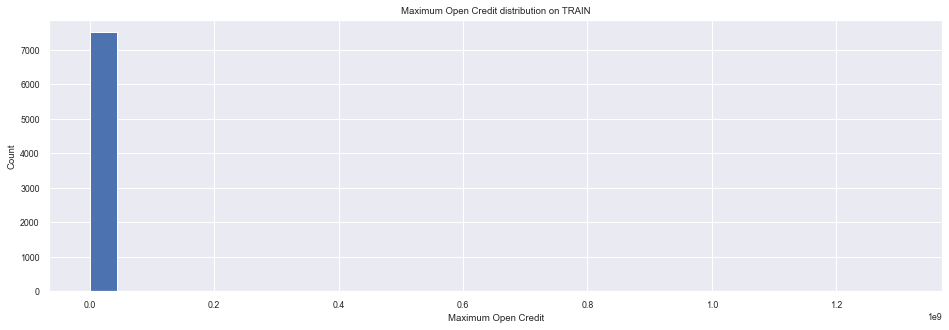

In [114]:
plt.figure(figsize = (16, 5))

train_df['Maximum Open Credit'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TRAIN')
plt.show()

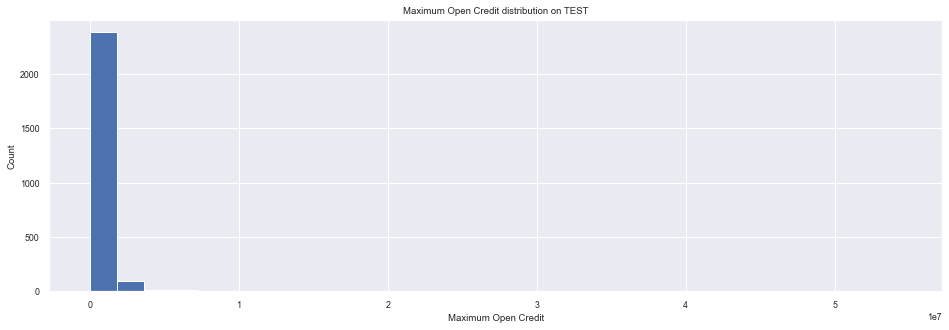

In [115]:
plt.figure(figsize = (16, 5))

test_df['Maximum Open Credit'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [116]:
train_df.loc[train_df['Maximum Open Credit'].sort_values().head(100).index]['Credit Default'].value_counts()

0    73
1    27
Name: Credit Default, dtype: int64

In [117]:
train_df.loc[train_df['Maximum Open Credit'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    88
1    12
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [118]:
train_df.loc[train_df['Maximum Open Credit'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    671
1    329
Name: Credit Default, dtype: int64

In [119]:
train_df.loc[train_df['Maximum Open Credit'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    773
1    227
Name: Credit Default, dtype: int64

видно, что на максимальных значениях Maximum Open Credit, доля объектов с целевой переменной = 1 существенно ниже, чем на минимальных значениях признака и в среднем по датасету

#### построим распределение признака на train и на test за минусом 100 наиболее высоких значений

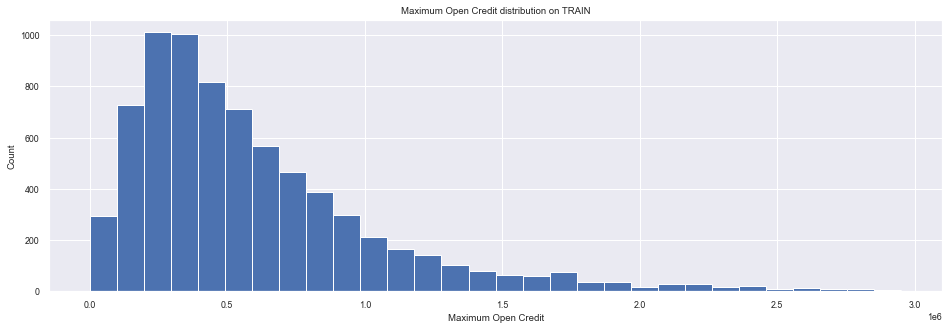

In [120]:
plt.figure(figsize = (16, 5))

train_df['Maximum Open Credit'].sort_values()[:-100].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TRAIN')
plt.show()

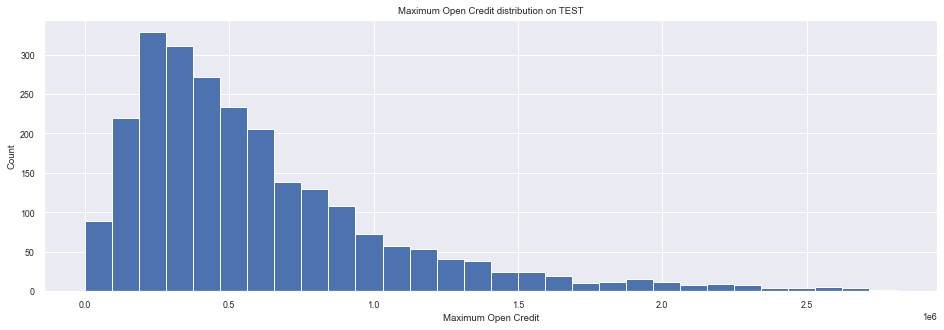

In [121]:
plt.figure(figsize = (16, 5))

test_df['Maximum Open Credit'].sort_values()[:-40].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TEST')
plt.show()

#### оценка признака Maximum Open Credit в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты за минусом 100 максимальных значений в Current Loan Amount

In [122]:
df = train_df.loc[train_df['Maximum Open Credit'].sort_values()[:-100].index].copy()

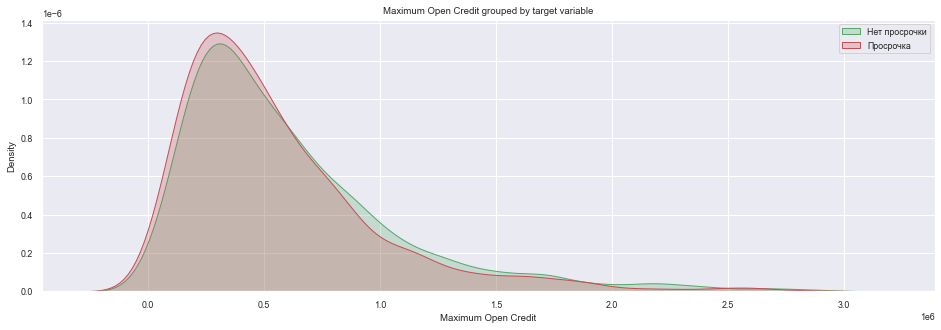

In [123]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Maximum Open Credit'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Maximum Open Credit'], shade=True, label='Просрочка', color='r')

plt.xlabel('Maximum Open Credit')
plt.title('Maximum Open Credit grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [124]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Maximum Open Credit'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Maximum Open Credit'])

MannwhitneyuResult(statistic=5166580.0, pvalue=6.915229604855069e-07)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

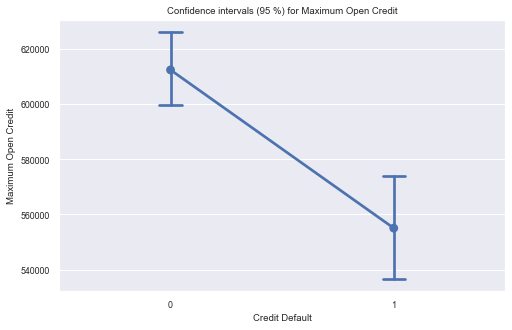

In [125]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=df[['Maximum Open Credit', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

In [126]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=10, 
                                                           feature_name='Maximum Open Credit',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=True, 
                                                           push_left_max_outliers=True)

in range from 70912.6 to 287441.76999999984
proportion of objects where target is 1: 0.32
number of objects: 1950

in range from 287441.76999999984 to 503970.9399999997
proportion of objects where target is 1: 0.29
number of objects: 1989

in range from 503970.9399999997 to 720500.1099999995
proportion of objects where target is 1: 0.28
number of objects: 1352

in range from 720500.1099999995 to 937029.2799999993
proportion of objects where target is 1: 0.27
number of objects: 858

in range from 937029.2799999993 to 1153558.4499999993
proportion of objects where target is 1: 0.25
number of objects: 466

in range from 1153558.4499999993 to 1370087.6199999992
proportion of objects where target is 1: 0.22
number of objects: 272

in range from 1370087.6199999992 to 1586616.7899999989
proportion of objects where target is 1: 0.23
number of objects: 162

in range from 1586616.7899999989 to 1803145.9599999988
proportion of objects where target is 1: 0.25
number of objects: 141

in range from 

Наблюдения:

    - Видна небольшая зависимость при которой чем выше Maximum Open Credit, тем меньше целевая переменная принимает значение = 1, что согласуется с банальной логикой - банки более тщательно подходят к проверке клиента при выдаче крупных кредитов.
    - Разделительная способность признака довольно слабая.
    
Идеи:

    - Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.
    - Смотреть как будет изменяться метрика при включении/исключении как оригинального, так и сгенерированного признака.

### Number of Open Accounts / количество открытых счетов

In [127]:
train_df['Number of Open Accounts'].isna().value_counts()

False    7500
Name: Number of Open Accounts, dtype: int64

#### посмотрим количество значений которые может принимать Number of Open Accounts

In [128]:
train_df['Number of Open Accounts'].value_counts().count()

39

#### построим распределение признака на train и на test

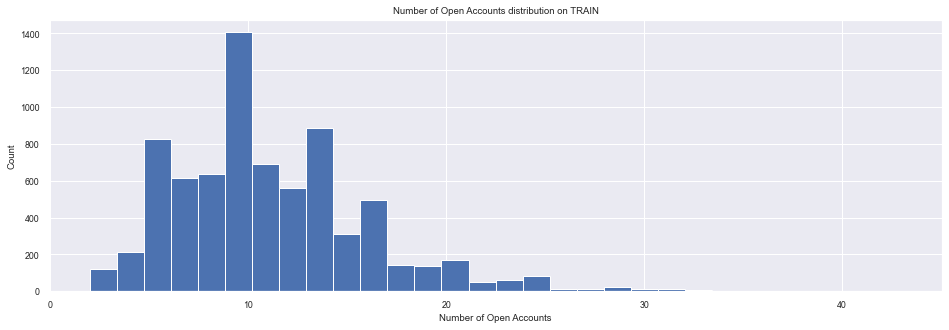

In [129]:
plt.figure(figsize = (16, 5))

train_df['Number of Open Accounts'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Number of Open Accounts')

plt.title('Number of Open Accounts distribution on TRAIN')
plt.show()

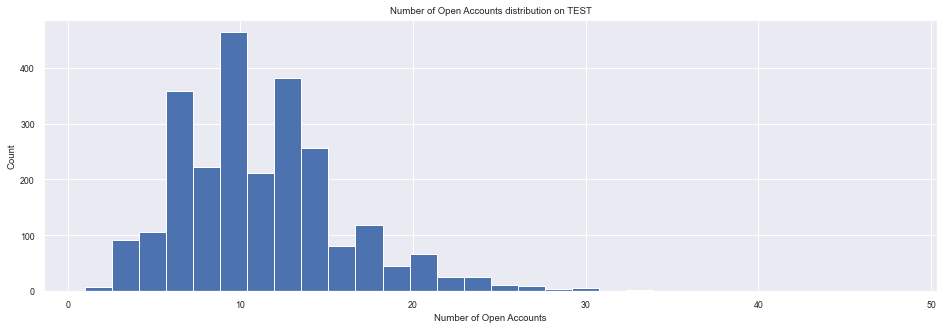

In [130]:
plt.figure(figsize = (16, 5))

test_df['Number of Open Accounts'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Number of Open Accounts')

plt.title('Number of Open Accounts distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [131]:
train_df.loc[train_df['Number of Open Accounts'].sort_values().head(100).index]['Credit Default'].value_counts()

0    73
1    27
Name: Credit Default, dtype: int64

In [132]:
train_df.loc[train_df['Number of Open Accounts'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    69
1    31
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [133]:
train_df.loc[train_df['Number of Open Accounts'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    725
1    275
Name: Credit Default, dtype: int64

In [134]:
train_df.loc[train_df['Number of Open Accounts'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    703
1    297
Name: Credit Default, dtype: int64

видно, что на максимальных значениях Number of Open Accounts, доля объектов с целевой переменной = 1 немного выше, чем на минимальных значениях признака и в среднем по датасету

#### оценка признака Maximum Open Credit в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты за минусом 100 максимальных значений в Current Loan Amount

In [135]:
df = train_df.loc[train_df['Number of Open Accounts'].sort_values()[:].index].copy()

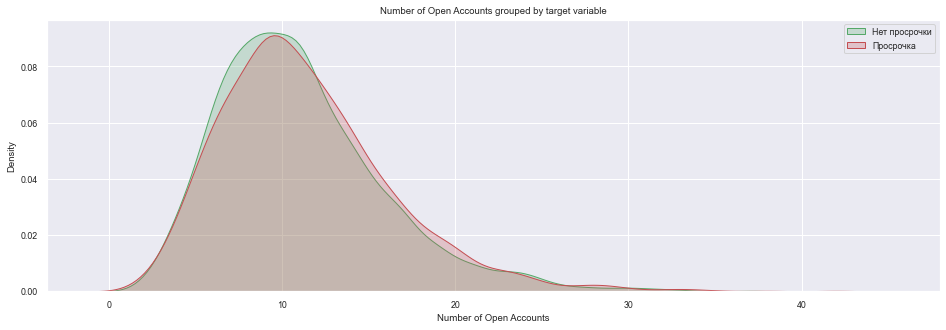

In [136]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Number of Open Accounts'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Number of Open Accounts'], shade=True, label='Просрочка', color='r')

plt.xlabel('Number of Open Accounts')
plt.title('Number of Open Accounts grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [137]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Number of Open Accounts'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Number of Open Accounts'])

MannwhitneyuResult(statistic=5466480.0, pvalue=0.003761646078803518)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

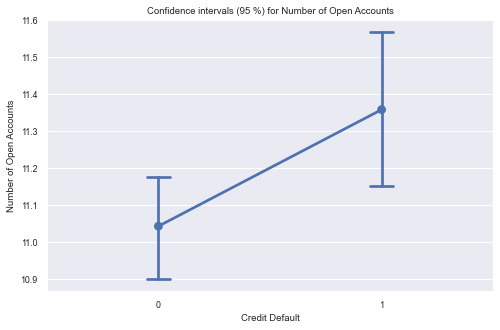

In [138]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=df[['Number of Open Accounts', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

In [139]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=5, 
                                                           feature_name='Number of Open Accounts',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=True)

in range from 2.0 to 6.2
proportion of objects where target is 1: 0.27
number of objects: 1164

in range from 6.2 to 10.4
proportion of objects where target is 1: 0.27
number of objects: 2656

in range from 10.4 to 14.600000000000001
proportion of objects where target is 1: 0.28
number of objects: 2139

in range from 14.600000000000001 to 18.8
proportion of objects where target is 1: 0.3
number of objects: 953

in range from 18.8 to 23.0
proportion of objects where target is 1: 0.31
number of objects: 359

----------------------------
number of categories: 5 + 0
feature name: Number of Open Accounts
target name: Credit Default




Наблюдения:

    - Признак обладает очень умеренной разделительной способностью.
    
Идеи:

    - Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.
    - Смотреть как будет изменяться метрика при включении/исключении как оригинального, так и сгенерированного признака.

### Years of Credit History / количество лет кредитной истории

In [140]:
train_df['Years of Credit History'].isna().value_counts()

False    7500
Name: Years of Credit History, dtype: int64

#### посмотрим количество значений которые может принимать Years of Credit History

In [141]:
train_df['Years of Credit History'].value_counts().count()

408

#### построим распределение признака на train и на test

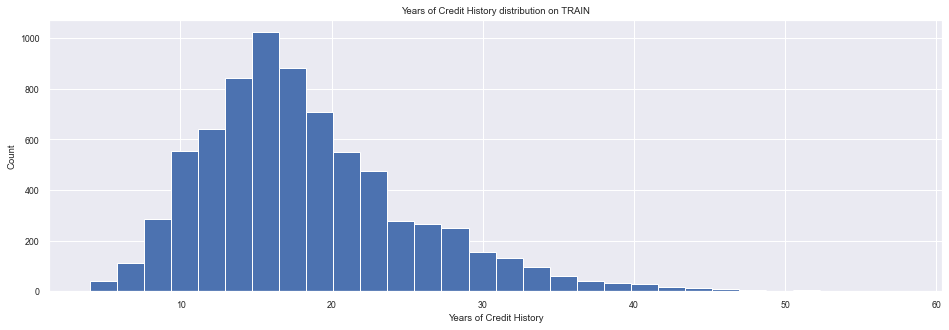

In [142]:
plt.figure(figsize = (16, 5))

train_df['Years of Credit History'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Years of Credit History')

plt.title('Years of Credit History distribution on TRAIN')
plt.show()

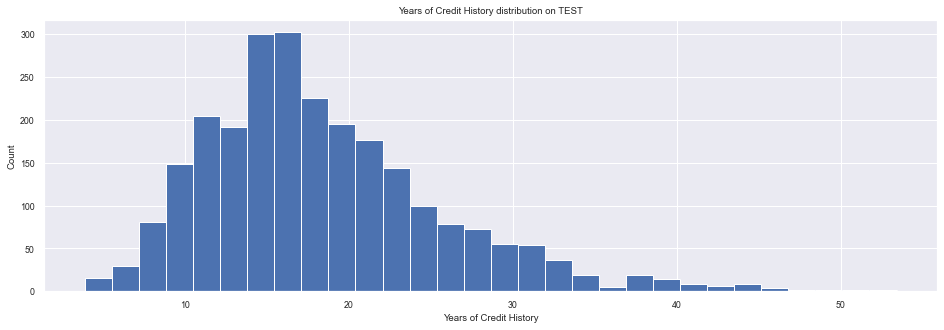

In [143]:
plt.figure(figsize = (16, 5))

test_df['Years of Credit History'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Years of Credit History')

plt.title('Years of Credit History distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [144]:
train_df.loc[train_df['Years of Credit History'].sort_values().head(100).index]['Credit Default'].value_counts()

0    72
1    28
Name: Credit Default, dtype: int64

In [145]:
train_df.loc[train_df['Years of Credit History'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    68
1    32
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [146]:
train_df.loc[train_df['Years of Credit History'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    673
1    327
Name: Credit Default, dtype: int64

In [147]:
train_df.loc[train_df['Years of Credit History'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    710
1    290
Name: Credit Default, dtype: int64

видно, что на максимальных значениях Number of Open Accounts, доля объектов с целевой переменной = 1 немного выше, чем на минимальных значениях признака и в среднем по датасету

#### оценка признака Years of Credit History в разрезе целевой переменной

In [148]:
df = train_df.copy()

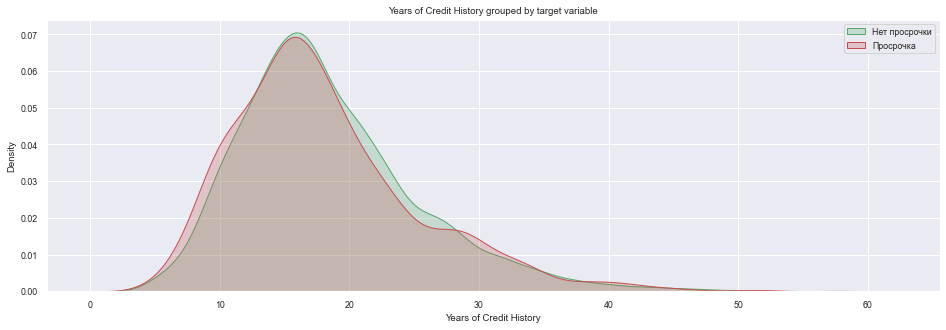

In [149]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Years of Credit History'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Years of Credit History'], shade=True, label='Просрочка', color='r')

plt.xlabel('Years of Credit History')
plt.title('Years of Credit History grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [150]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Years of Credit History'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Years of Credit History'])

MannwhitneyuResult(statistic=5461129.5, pvalue=0.003171215731103466)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

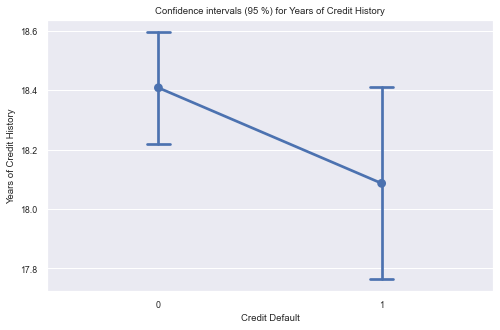

In [151]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=df[['Years of Credit History', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Years of Credit History')
plt.show()

In [152]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=10, 
                                                           feature_name='Years of Credit History',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

in range from 4.0 to 9.370000000000001
proportion of objects where target is 1: 0.33
number of objects: 436

in range from 9.370000000000001 to 14.74
proportion of objects where target is 1: 0.29
number of objects: 2032

in range from 14.74 to 20.11
proportion of objects where target is 1: 0.28
number of objects: 2610

in range from 20.11 to 25.48
proportion of objects where target is 1: 0.25
number of objects: 1302

in range from 25.48 to 30.85
proportion of objects where target is 1: 0.28
number of objects: 672

in range from 30.85 to 36.22
proportion of objects where target is 1: 0.28
number of objects: 289

in range from 36.22 to 41.59
proportion of objects where target is 1: 0.3
number of objects: 101

in range from 41.59 to 46.96
proportion of objects where target is 1: 0.29
number of objects: 42

in range from 46.96 to 52.33
proportion of objects where target is 1: 0.27
number of objects: 15

in range from 52.33 to 57.7
----------------------------
number of categories: 10 + 0
f

Наблюдения:

    - Признак обладает очень умеренной разделительной способностью.
    
Идеи:

    - Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.
    - Смотреть как будет изменяться метрика при включении/исключении как оригинального, так и сгенерированного признака.

### Current Credit Balance / текущий кредитный баланс

In [153]:
train_df['Current Credit Balance'].isna().value_counts()

False    7500
Name: Current Credit Balance, dtype: int64

#### построим распределение признака на train и на test

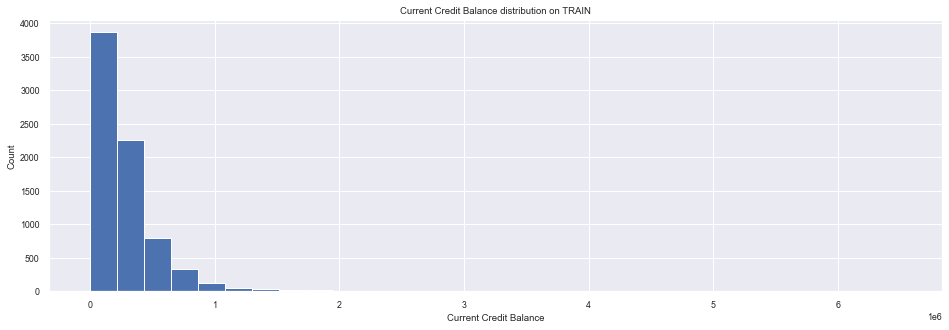

In [154]:
plt.figure(figsize = (16, 5))

train_df['Current Credit Balance'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Credit Balance')

plt.title('Current Credit Balance distribution on TRAIN')
plt.show()

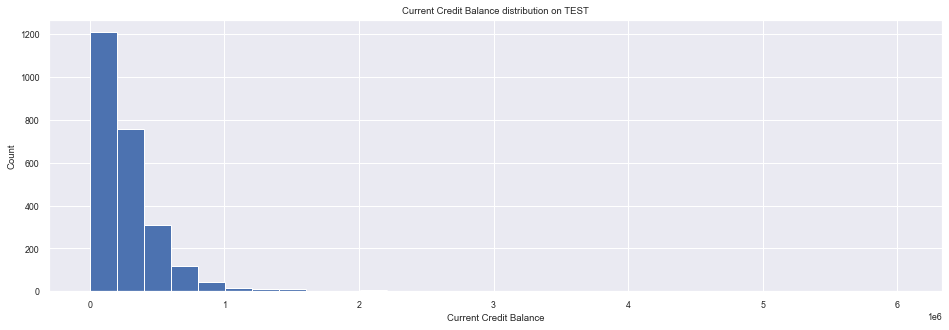

In [155]:
plt.figure(figsize = (16, 5))

test_df['Current Credit Balance'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Current Credit Balance')

plt.title('Current Credit Balance distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [156]:
train_df.loc[train_df['Current Credit Balance'].sort_values().head(100).index]['Credit Default'].value_counts()

0    84
1    16
Name: Credit Default, dtype: int64

In [157]:
train_df.loc[train_df['Current Credit Balance'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    83
1    17
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [158]:
train_df.loc[train_df['Current Credit Balance'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    719
1    281
Name: Credit Default, dtype: int64

In [159]:
train_df.loc[train_df['Current Credit Balance'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    726
1    274
Name: Credit Default, dtype: int64

на минимально низких и максимально высоких значениях Current Credit Balance (head(100) и tail(100)), доля объектов с целевой переменной = 1 меньше, чем на более больших выборках слева и справа на пространстве значений признака.

#### оценка признака Current Credit Balance в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты за минусом 100 максимальных значений в Current Credit Balance

In [160]:
# df = train_df.copy()
df = train_df.loc[train_df['Current Credit Balance'].sort_values()[:-100].index].copy()

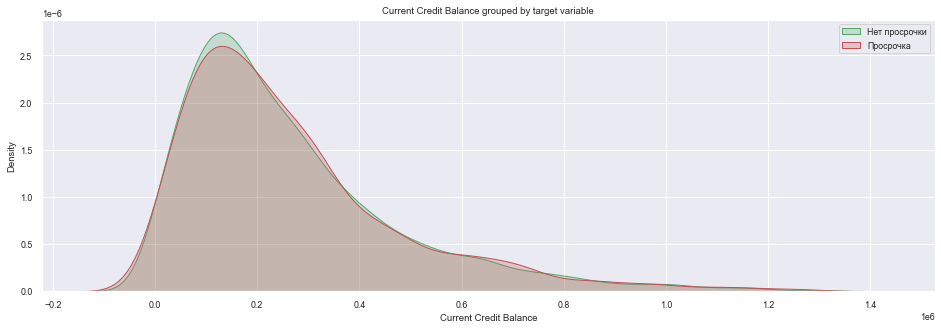

In [161]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Current Credit Balance'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Current Credit Balance'], shade=True, label='Просрочка', color='r')

plt.xlabel('Current Credit Balance')
plt.title('Current Credit Balance grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [162]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Years of Credit History'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Years of Credit History'])

MannwhitneyuResult(statistic=5354352.5, pvalue=0.006820548851190548)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

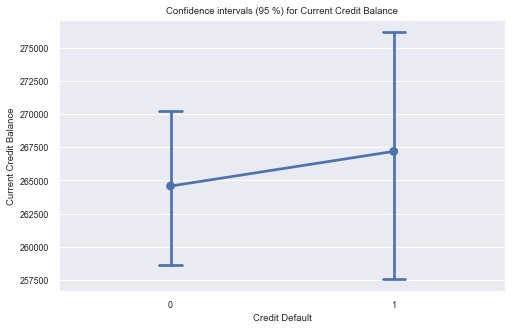

In [163]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=df[['Current Credit Balance', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

In [164]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=5, 
                                                           feature_name='Current Credit Balance',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=True)

in range from 0.0 to 200315.9549999995
proportion of objects where target is 1: 0.28
number of objects: 3611

in range from 200315.9549999995 to 400631.909999999
proportion of objects where target is 1: 0.29
number of objects: 2302

in range from 400631.909999999 to 600947.8649999985
proportion of objects where target is 1: 0.28
number of objects: 847

in range from 600947.8649999985 to 801263.819999998
proportion of objects where target is 1: 0.3
number of objects: 401

in range from 801263.819999998 to 1001579.7749999975
proportion of objects where target is 1: 0.28
number of objects: 151

----------------------------
number of categories: 5 + 0
feature name: Current Credit Balance
target name: Credit Default




Наблюдения:

    - Признак обладает очень слабой разделительной способностью.
    
Идеи:

    - Выкинуть признак.

### Monthly Debt / ежемесячный долг

#### построим распределение признака на train и на test

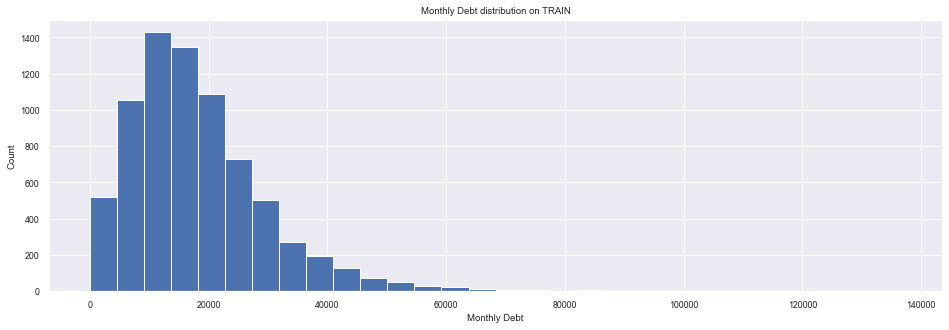

In [166]:
plt.figure(figsize = (16, 5))

train_df['Monthly Debt'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Monthly Debt')

plt.title('Monthly Debt distribution on TRAIN')
plt.show()

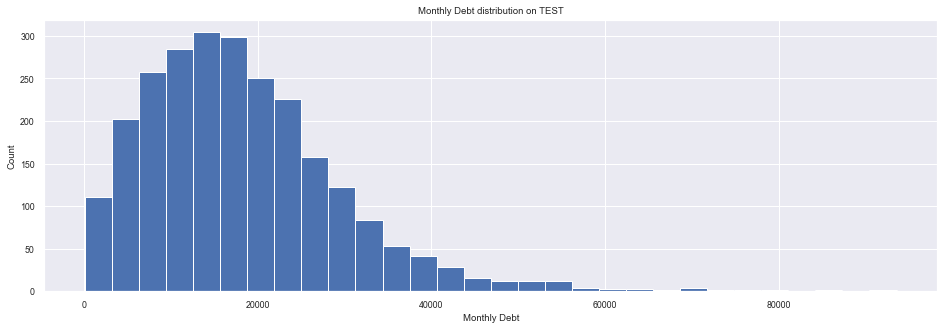

In [167]:
plt.figure(figsize = (16, 5))

test_df['Monthly Debt'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Monthly Debt')

plt.title('Monthly Debt distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [168]:
train_df.loc[train_df['Monthly Debt'].sort_values().head(100).index]['Credit Default'].value_counts()

0    82
1    18
Name: Credit Default, dtype: int64

In [169]:
train_df.loc[train_df['Monthly Debt'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    70
1    30
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [170]:
train_df.loc[train_df['Monthly Debt'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    743
1    257
Name: Credit Default, dtype: int64

In [171]:
train_df.loc[train_df['Monthly Debt'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    707
1    293
Name: Credit Default, dtype: int64

на низких значениях Monthly Debt, доля объектов с целевой переменной = 1 меньше, чем на более в диапазоне значений справа.

#### оценка признака в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты за минусом 100 максимальных значений

In [172]:
# df = train_df.copy()
df = train_df.loc[train_df['Monthly Debt'].sort_values()[:-100].index].copy()

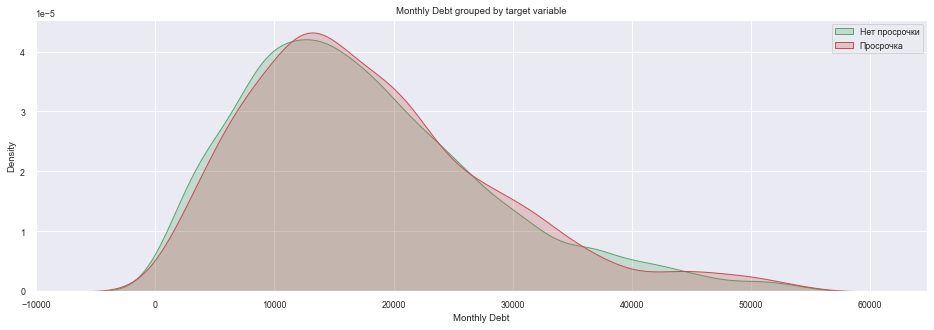

In [173]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Monthly Debt'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Monthly Debt'], shade=True, label='Просрочка', color='r')

plt.xlabel('Monthly Debt')
plt.title('Monthly Debt grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [174]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Monthly Debt'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Monthly Debt'])

MannwhitneyuResult(statistic=5388132.5, pvalue=0.03521403520369678)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

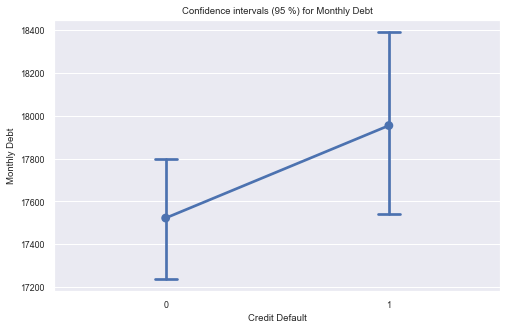

In [175]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=df[['Monthly Debt', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly Debt')
plt.show()

In [176]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=10, 
                                                           feature_name='Monthly Debt',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=True)

in range from 0.0 to 4795.014999999997
proportion of objects where target is 1: 0.23
number of objects: 574

in range from 4795.014999999997 to 9590.029999999993
proportion of objects where target is 1: 0.27
number of objects: 1139

in range from 9590.029999999993 to 14385.044999999991
proportion of objects where target is 1: 0.29
number of objects: 1530

in range from 14385.044999999991 to 19180.059999999987
proportion of objects where target is 1: 0.29
number of objects: 1358

in range from 19180.059999999987 to 23975.074999999983
proportion of objects where target is 1: 0.29
number of objects: 1054

in range from 23975.074999999983 to 28770.089999999982
proportion of objects where target is 1: 0.29
number of objects: 688

in range from 28770.089999999982 to 33565.104999999974
proportion of objects where target is 1: 0.31
number of objects: 449

in range from 33565.104999999974 to 38360.11999999997
proportion of objects where target is 1: 0.28
number of objects: 256

in range from 38

Наблюдения:

    - Признак обладает очень умеренной разделительной способностью.
    
Идеи:

    - Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.
    - Смотреть как будет изменяться метрика при включении/исключении как оригинального, так и сгенерированного признака.

### Months since last delinquent / количество месяцев с последней просрочки платежа

In [177]:
train_df['Months since last delinquent'].isna().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

#### построим распределение признака на train и на test

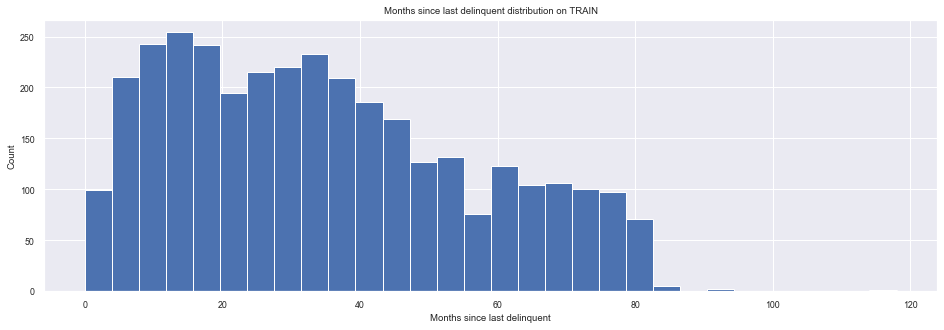

In [178]:
plt.figure(figsize = (16, 5))

train_df['Months since last delinquent'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Months since last delinquent')

plt.title('Months since last delinquent distribution on TRAIN')
plt.show()

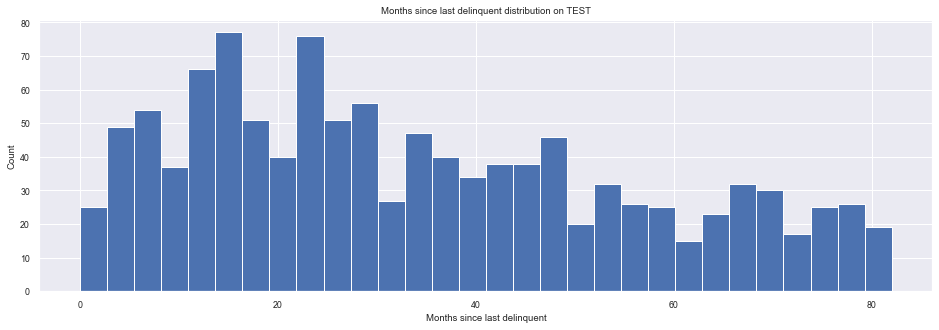

In [179]:
plt.figure(figsize = (16, 5))

test_df['Months since last delinquent'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Months since last delinquent')

plt.title('Months since last delinquent distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [180]:
train_df.loc[train_df['Months since last delinquent'].sort_values().head(100).index]['Credit Default'].value_counts()

0    68
1    32
Name: Credit Default, dtype: int64

In [181]:
train_df.loc[train_df['Months since last delinquent'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    68
1    32
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [182]:
train_df.loc[train_df['Months since last delinquent'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    704
1    296
Name: Credit Default, dtype: int64

In [183]:
train_df.loc[train_df['Months since last delinquent'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    704
1    296
Name: Credit Default, dtype: int64

на 100 самых низких и 100 самых высоких, как и на 1000 самых высоких и 1000 самых низких значений Months since last delinquent, доли объектов с целевой переменной = 1 абсолютно идентичны

#### оценка признака в разрезе целевой переменной

In [184]:
df = train_df.copy()
# df = train_df.loc[train_df['Monthly Debt'].sort_values()[:-100].index].copy()

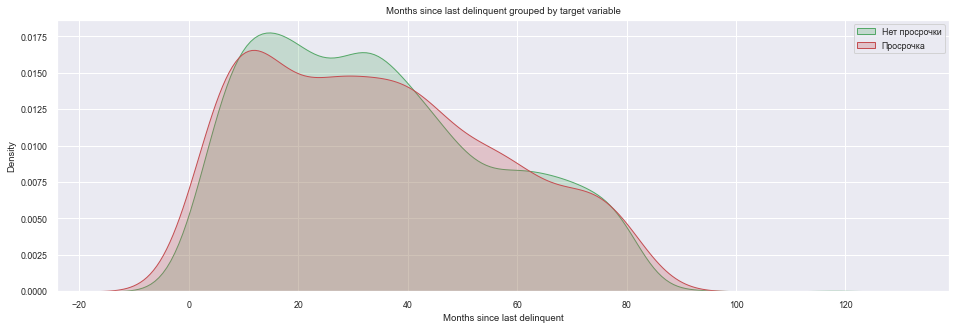

In [185]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Months since last delinquent'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Months since last delinquent'], shade=True, label='Просрочка', color='r')

plt.xlabel('Months since last delinquent')
plt.title('Months since last delinquent grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [186]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Months since last delinquent'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Months since last delinquent'])

MannwhitneyuResult(statistic=4187753.5, pvalue=2.2303574646660457e-71)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

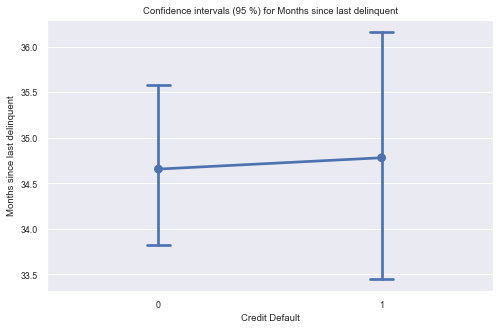

In [187]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', 
              data=df[['Months since last delinquent', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Months since last delinquent')
plt.show()

In [188]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=10, 
                                                           feature_name='Months since last delinquent',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

NaN objects detected!
additional category for NaN objects was created!
proportion of objects where target is 1: 0.28
number of objects: 4081

in range from 0.0 to 11.8
proportion of objects where target is 1: 0.32
number of objects: 552

in range from 11.8 to 23.6
proportion of objects where target is 1: 0.25
number of objects: 691

in range from 23.6 to 35.400000000000006
proportion of objects where target is 1: 0.27
number of objects: 668

in range from 35.400000000000006 to 47.2
proportion of objects where target is 1: 0.3
number of objects: 564

in range from 47.2 to 59.0
proportion of objects where target is 1: 0.33
number of objects: 335

in range from 59.0 to 70.80000000000001
proportion of objects where target is 1: 0.26
number of objects: 333

in range from 70.80000000000001 to 82.60000000000001
proportion of objects where target is 1: 0.31
number of objects: 268

in range from 82.60000000000001 to 94.4
proportion of objects where target is 1: 0.57
number of objects: 7

in ran

Наблюдения:

    - Признак обладает очень слабой разделительной способностью.
    
Идеи:

    - Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.
    - Смотреть как будет изменяться метрика при включении/исключении как оригинального, так и сгенерированного признака.

### Credit Score

In [190]:
train_df['Credit Score'].isna().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

#### построим распределение признака на train и на test

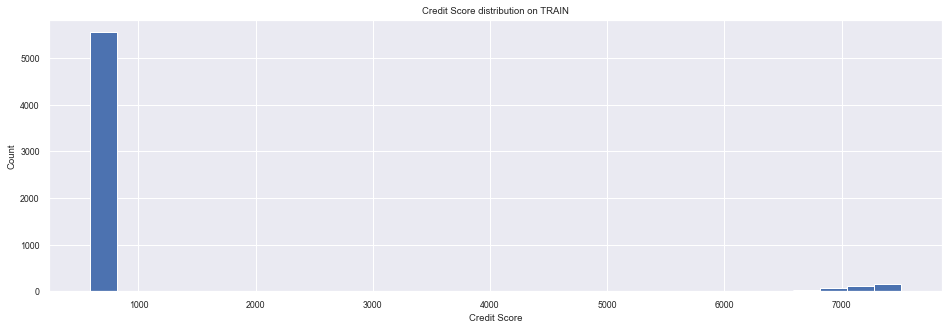

In [191]:
plt.figure(figsize = (16, 5))

train_df['Credit Score'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('Credit Score distribution on TRAIN')
plt.show()

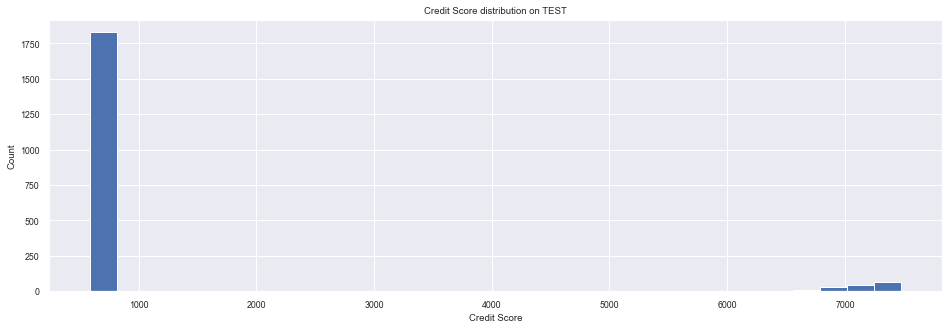

In [192]:
plt.figure(figsize = (16, 5))

test_df['Credit Score'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('Credit Score distribution on TEST')
plt.show()

#### посмотрим на минимальные и максимальные значения в разрезе целевой переменной

In [193]:
train_df.loc[train_df['Credit Score'].sort_values().head(100).index]['Credit Default'].value_counts()

1    50
0    50
Name: Credit Default, dtype: int64

In [194]:
train_df.loc[train_df['Credit Score'].sort_values().tail(100).index]['Credit Default'].value_counts()

0    73
1    27
Name: Credit Default, dtype: int64

#### увеличим количество объектов до 1000 

In [195]:
train_df.loc[train_df['Credit Score'].sort_values().head(1000).index]['Credit Default'].value_counts()

0    642
1    358
Name: Credit Default, dtype: int64

In [196]:
train_df.loc[train_df['Credit Score'].sort_values().tail(1000).index]['Credit Default'].value_counts()

0    667
1    333
Name: Credit Default, dtype: int64

на низких значениях Credit Score, доля объектов с целевой переменной = 1 больше, чем на противоположном цонце спектра значений

#### оценка признака в разрезе целевой переменной

In [184]:
df = train_df.copy()
# df = train_df.loc[train_df['Credit Score'].sort_values()[:-100].index].copy()

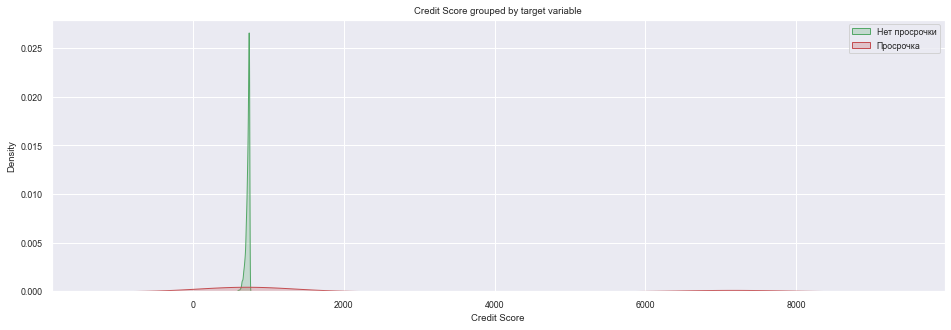

In [199]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Credit Score'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Credit Score'], shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [201]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Credit Score'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Credit Score'])

MannwhitneyuResult(statistic=5197665.0, pvalue=2.4094608408145815e-09)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

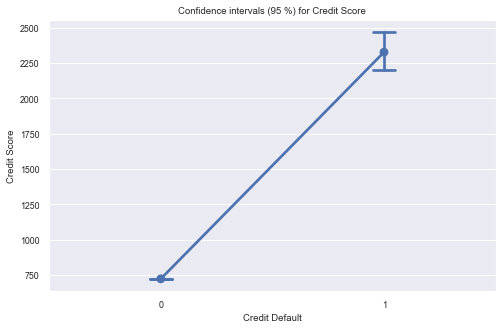

In [202]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', 
              data=df[['Credit Score', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

In [245]:
# df = train_df.loc[train_df['Current Loan Amount'].sort_values()[:-870].index].copy()
df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=4, 
                                                           feature_name='Credit Score',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

NaN objects detected!
additional category for NaN objects was created!
proportion of objects where target is 1: 0.34
number of objects: 1557

in range from 585.0 to 2316.25
proportion of objects where target is 1: 0.21
number of objects: 5543

in range from 2316.25 to 4047.5
in range from 4047.5 to 5778.75
in range from 5778.75 to 7510.0
proportion of objects where target is 1: 1.0
number of objects: 398

----------------------------
number of categories: 4 + 1
feature name: Credit Score
target name: Credit Default




# БИНГО№2!!! КАК ВИДНО, ВСЕ ЗНАЧЕНИЯ Credit Score > 1000 ИМЕЮТ ЦЕЛЕВУЮ ПЕРЕМЕННУЮ == 1

#### посмотрим, сколько таких значений на train и на test

In [210]:
train_df[train_df['Credit Score'] > 1000]['Credit Score'].count()

400

In [211]:
test_df[test_df['Credit Score'] > 1000]['Credit Score'].count()

160

#### построим распределения Credit Score для train и test датасетов без обнаруженных выше очень полезных выбросов

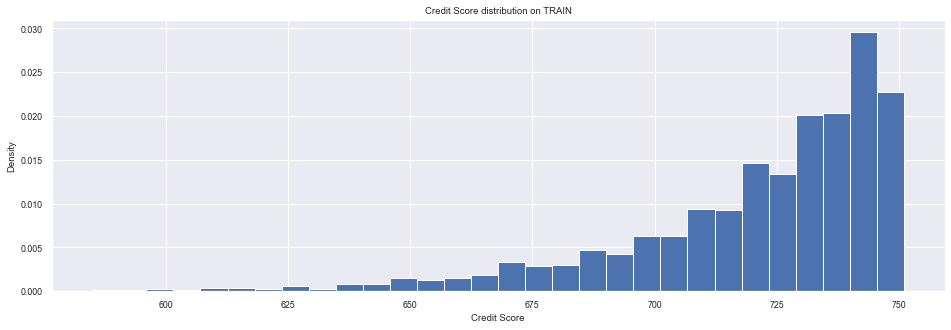

In [220]:
plt.figure(figsize = (16, 5))

train_df[train_df['Credit Score'] <= 1000]['Credit Score'].hist(bins=30, density=True)
plt.ylabel('Density')
plt.xlabel('Credit Score')

plt.title('Credit Score distribution on TRAIN')
plt.show()

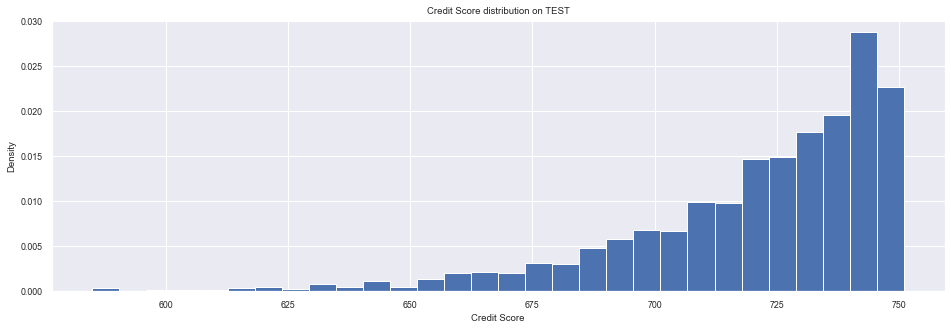

In [224]:
plt.figure(figsize = (16, 5))

test_df[test_df['Credit Score'] <= 1000]['Credit Score'].hist(bins=30, density=True)
plt.ylabel('Density')
plt.xlabel('Credit Score')

plt.title('Credit Score distribution on TEST')
plt.show()

#### посмотрим также какие пропуски в других признаках попадают в выбросы на Credit Score

In [225]:
train_df[train_df['Credit Score'] > 1000].isna().sum()

Home Ownership                    0
Annual Income                     0
Years in current job             18
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent    216
Bankruptcies                      3
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

Наблюдения:

    - Объекты с Credit Score > 1000 все отнесены к классу 1 целевой переменной.
    - В объектах с Credit Score > 1000 имеются пропуски в других признаках.
    - Распределения на train и test схожи.
    
Идеи:

    - Исключить объекты с Credit Score > 1000 из обучения модели, а на test датафрейме присвоить всем таким объектам класс 1 в целевой переменной.

#### оценка признака Credit Score (без выбросов) в разрезе целевой переменной

создадим копию train датафрема куда войдут объекты без выбросов в Current Loan Amount

In [226]:
df = train_df[train_df['Credit Score'] <= 1000].copy()

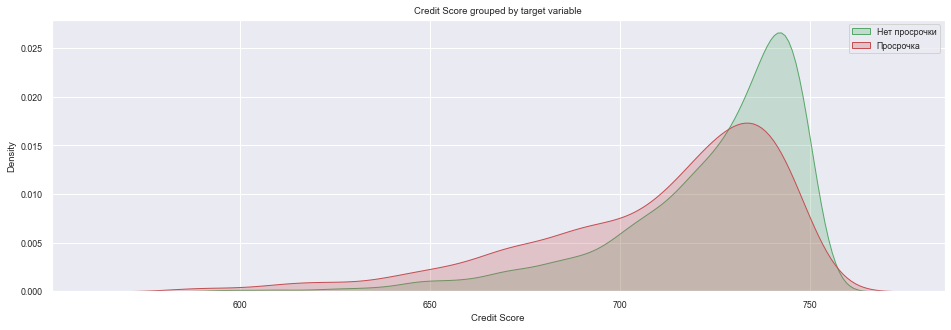

In [227]:
plt.figure(figsize=(16, 5))

sns.kdeplot(df.loc[train_df[TARGET_NAME] == 0, 'Credit Score'], shade=True, label='Нет просрочки', color='g')
sns.kdeplot(df.loc[train_df[TARGET_NAME] == 1, 'Credit Score'], shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.legend()
plt.show()

#### оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [228]:
mannwhitneyu(df.loc[train_df[TARGET_NAME] == 0, 'Credit Score'], 
             df.loc[train_df[TARGET_NAME] == 1, 'Credit Score'])

MannwhitneyuResult(statistic=1872400.0, pvalue=5.690429274717866e-48)

p-value меньше alpha, значит матожидания не равны и признак обладает разделительной способностью по отношению к целевой переменной

#### построим доверительные интервалы для средних значений, каждой из двух групп и сравним их

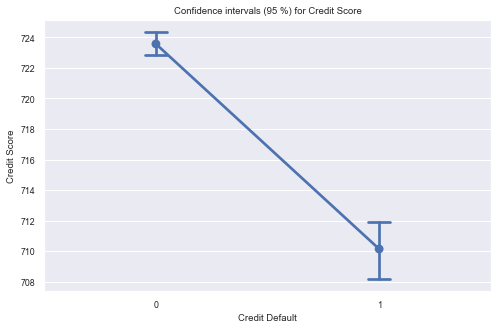

In [229]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=df[['Credit Score', TARGET_NAME]], capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

In [237]:
train_df['Credit Score'].isna().value_counts()

False    5943
True     1557
Name: Credit Score, dtype: int64

In [241]:
df['Credit Score'].isna().value_counts()

Series([], Name: Credit Score, dtype: int64)

In [246]:
# df = train_df.loc[train_df['Credit Score'].sort_values()[:-870].index].copy()
df = train_df[(train_df['Credit Score'] <= 1000) | train_df['Credit Score'].isna()].copy()
# df = train_df.copy()

check_whether_categorization_with_target_encoding_is_valid(df=df, 
                                                           number_of_categories=20, 
                                                           feature_name='Credit Score',
                                                           target_name=TARGET_NAME, 
                                                           push_right_min_outliers=False, 
                                                           push_left_max_outliers=False)

NaN objects detected!
additional category for NaN objects was created!
proportion of objects where target is 1: 0.34
number of objects: 1557

in range from 585.0 to 593.3
proportion of objects where target is 1: 0.86
number of objects: 7

in range from 593.3 to 601.6
proportion of objects where target is 1: 0.3
number of objects: 10

in range from 601.6 to 609.9
proportion of objects where target is 1: 0.44
number of objects: 9

in range from 609.9 to 618.2
proportion of objects where target is 1: 0.59
number of objects: 17

in range from 618.2 to 626.5
proportion of objects where target is 1: 0.61
number of objects: 18

in range from 626.5 to 634.8
proportion of objects where target is 1: 0.33
number of objects: 18

in range from 634.8 to 643.1
proportion of objects where target is 1: 0.43
number of objects: 35

in range from 643.1 to 651.4
proportion of objects where target is 1: 0.34
number of objects: 61

in range from 651.4 to 659.7
proportion of objects where target is 1: 0.4
num

Наблюдения:

- Credit Default с убранными выбросами обладает отличной разделительной способностью в разрезе целевой переменной.

Идеи:

- Cоздать новый признак при помощи функции generate_target_encoded_feature_for_a_numerical_feature.

In [189]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)